In [2]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy
from scipy import stats
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline


%load_ext autoreload
%autoreload 2

# import gzip
# from cyvcf2 import VCF

from sklearn.linear_model import LinearRegression

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()



In [3]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)



In [4]:
### Now that we've drawn that line, let's purge the Li2019 mutants from the list


merged_fitness = merged_fitness[~merged_fitness['source_publication'].isin(['Li2019'])]

WT PearsonRResult(statistic=-0.5211449176873438, pvalue=1.2290857529294809e-09)
CYR1 PearsonRResult(statistic=-0.20016913585149418, pvalue=0.11878568863301561)
GPB2 PearsonRResult(statistic=-0.09637199191403109, pvalue=0.7541348175885495)
TOR1 PearsonRResult(statistic=-0.22124445277360602, pvalue=0.1395046851122474)
IRA1_MIS PearsonRResult(statistic=-0.3972369007856157, pvalue=0.00010591478920693106)
IRA1_NON PearsonRResult(statistic=-0.05564032433726551, pvalue=0.5922691387104273)


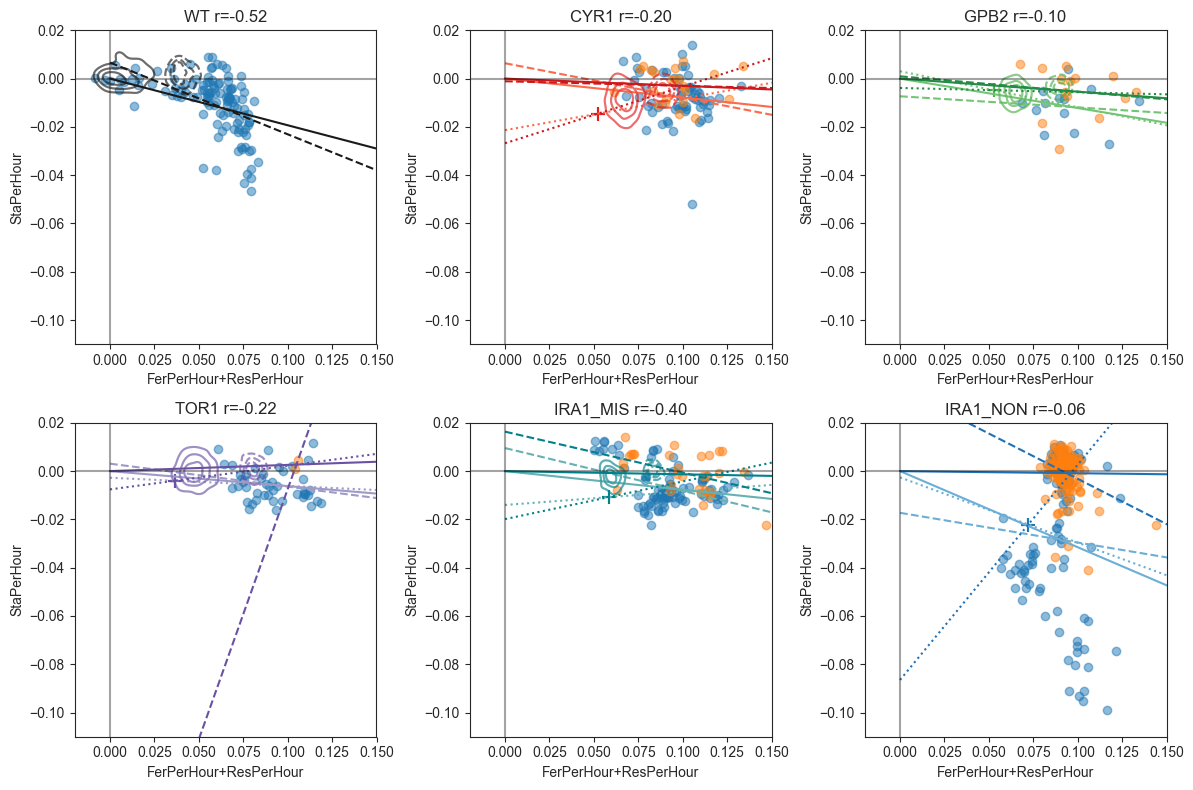

In [4]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 

xdata = 'FerPerHour+ResPerHour'
ydata = 'StaPerHour'




plt.figure(figsize=(12,8))
for a,anc in enumerate(ancestor_list):
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
    for evo_cond in evo_cond_list:
    
        this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

        sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

        this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

        sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
        if evo_cond == 'Evo2D':
            print(anc,scipy.stats.pearsonr(this_data[xdata].values,this_data[ydata].values))
            plt.title(f'{anc} r={np.corrcoef(this_data[xdata].values,this_data[ydata].values)[0,1]:.2f}')
        
        
        plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.5)
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
        if len(this_data[xdata].values) > 0:
            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                              ,this_data[ydata].values-background_mutant[ydata].values)

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                         ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
#                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
#                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])

        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
            
    
    plt.xlim(-0.02,0.15)
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)
    
    plt.axhline(0,color='k',alpha=0.4)
    plt.axvline(0,color='k',alpha=0.4)
    
plt.tight_layout()

IRA1_NON (0.9449903851330687, 6.391674473870874e-47)
IRA1_NON (0.9449903851330687, 6.391674473870874e-47)
IRA1_NON (0.9449903851330687, 6.391674473870874e-47)
IRA1_NON (0.9449903851330687, 6.391674473870874e-47)
IRA1_NON (0.9449903851330687, 6.391674473870874e-47)
IRA1_NON (0.9449903851330687, 6.391674473870874e-47)


ValueError: num must be 1 <= num <= 6, not 7

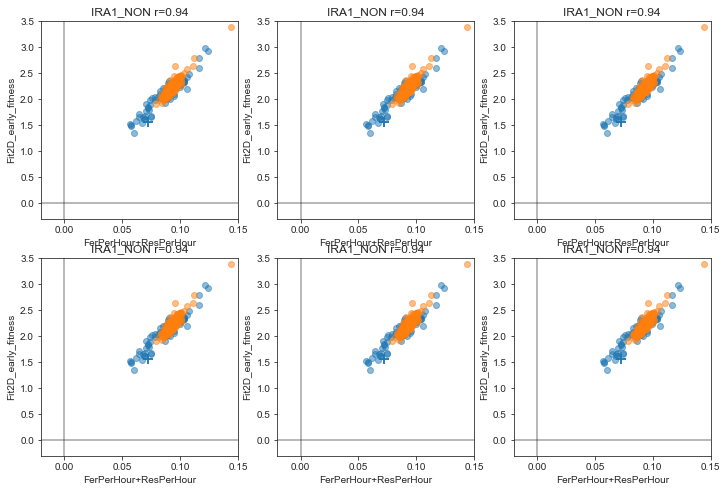

In [125]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 

xdata = 'FerPerHour+ResPerHour'
ydata = 'Fit2D_early_fitness'


plt.figure(figsize=(12,8))
for a,ancs in enumerate(ancestor_list):
    
#     i
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
    for evo_cond in evo_cond_list:
    
        this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

        sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

        this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

        sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
        if evo_cond == 'Evo2D':
            print(anc,scipy.stats.pearsonr(this_data[xdata].values,this_data[ydata].values))
            plt.title(f'{anc} r={np.corrcoef(this_data[xdata].values,this_data[ydata].values)[0,1]:.2f}')
        
        
        plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.5)
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
#         if len(this_data[xdata].values) > 0:
#             reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

#             xs = np.linspace(0,3,100)
#             plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
#             reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

#             xs = np.linspace(0,3,100)
#             plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
#             if anc != 'WT':
#                 background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


#                 reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
#                                               ,this_data[ydata].values-background_mutant[ydata].values)

#                 xs = np.linspace(0,3,100)
#                 plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
#                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
# #                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
# #                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])

        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
            
    
    plt.xlim(-0.02,0.15)
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)
    
    plt.axhline(0,color='k',alpha=0.4)
    plt.axvline(0,color='k',alpha=0.4)
    
plt.tight_layout()

No handles with labels found to put in legend.


WT
['Evo2D']
WT ['Evo2D'] -0.297044296616903 0.006651244055914657 1.2290857529294842e-09
CYR1
['Evo2D']
CYR1 ['Evo2D'] -0.06355701478430704 -0.00173022094456372 0.48776084371406747
GPB2
['Evo2D']
GPB2 ['Evo2D'] 0.046539482346348866 -0.016721821099017646 0.7245123742958539
TOR1
['Evo2D']
TOR1 ['Evo2D'] -0.09491084835652105 0.003082275784556868 0.13950468511224717
IRA1_MIS
['Evo2D']
IRA1_MIS ['Evo2D'] -0.17726964714377214 0.00954926010572185 0.00010591478920693078
IRA1_NON
['Evo2D']
IRA1_NON ['Evo2D'] -0.12303202954957529 -0.017270174549129998 0.5922691387104249


No handles with labels found to put in legend.
No handles with labels found to put in legend.


CYR1
['Evo3D']
CYR1 ['Evo3D'] -0.018796009601783525 -0.0010915297892049357 0.8446413616195332
GPB2
['Evo3D']
GPB2 ['Evo3D'] -0.06344007204287506 0.0009492769735670887 0.6918589985803012
TOR1
['Evo3D']
TOR1 ['Evo3D'] 2.0705966798523314 -0.21452894312647386 0.0
IRA1_MIS
['Evo3D']
IRA1_MIS ['Evo3D'] -0.16974525680848535 0.016343174526729107 0.011985192904054743
IRA1_NON
['Evo3D']
IRA1_NON ['Evo3D'] -0.37490261000431274 0.03430883805265129 0.00029620836607784226


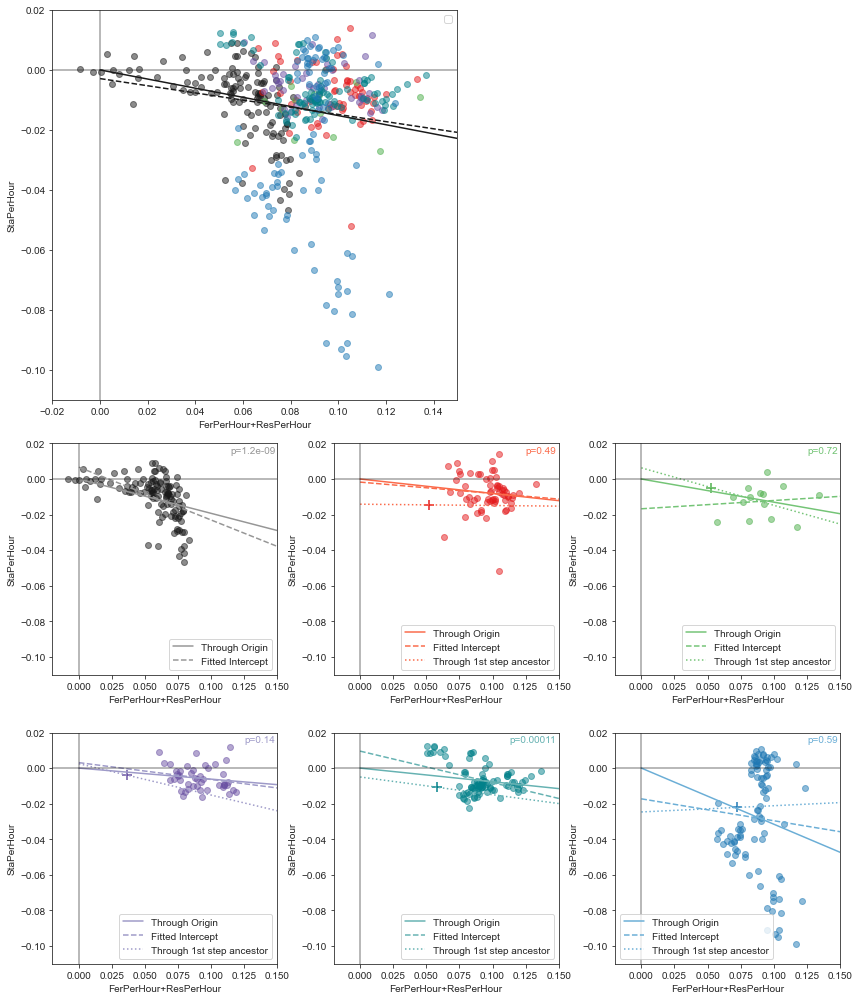

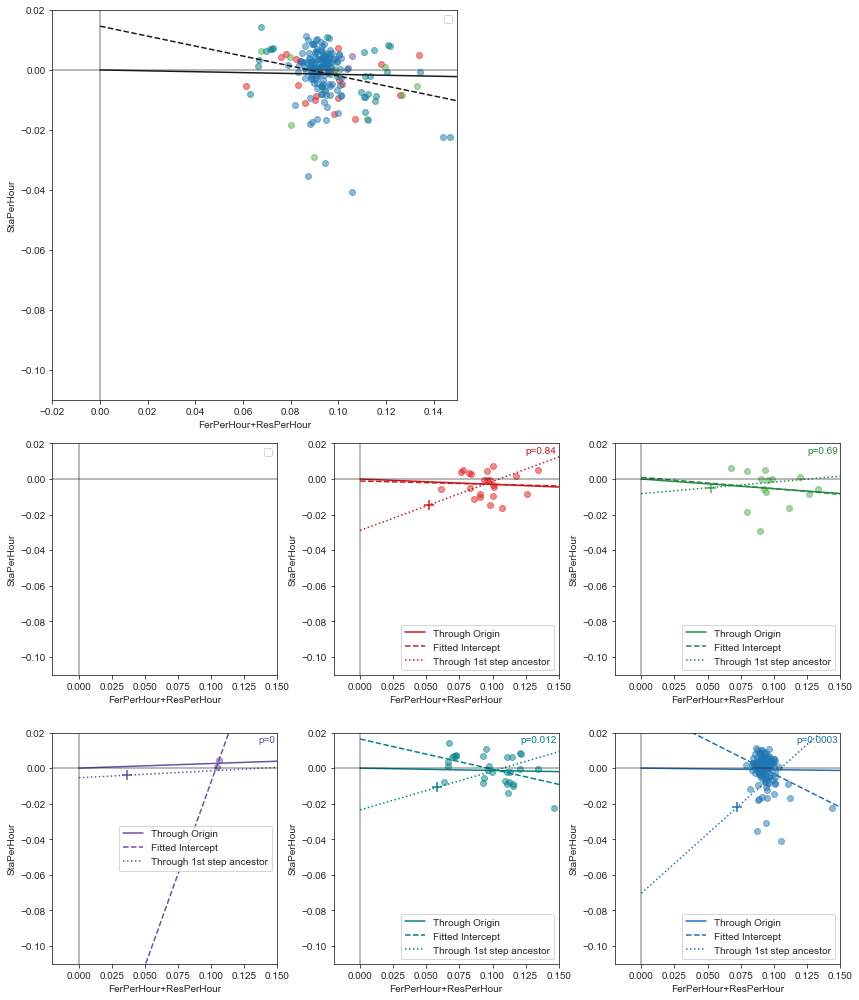

In [135]:

evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]
evo_cond_list = [['Evo2D'],['Evo3D']]
ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 
xdata = 'FerPerHour+ResPerHour'
ydata = 'StaPerHour'

# merged_fitness['ResPerHour+StaPerHour'] = merged_fitness['ResPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'ResPerHour+StaPerHour'
# ydata = 'FerPerHour'

# merged_fitness['FerPerHour+StaPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'FerPerHour+StaPerHour'
# ydata = 'ResPerHour'
                 
for evo_cond in evo_cond_list:
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,2,2],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        
        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])


        this_anc = merged_fitness

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
        this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

        for anc in ancs:
            anc_here = this_data[this_data['ancestor']==anc]
            plt.scatter(anc_here[xdata].values,
                        anc_here[ydata].values,
                        alpha=0.5,color=tools.anc_color_map[anc])
            
            if len(anc_here[xdata].values) > 0 and len(ancs) == 1:
                print(anc)
                print(evo_cond)
                reg = LinearRegression(fit_intercept = False).fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through Origin')
            
                reg2 = LinearRegression().fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)
                
                slope, intercept, r_value, p_value, std_err = stats.linregress(x=anc_here[xdata].values.reshape(-1, 1)[:,0],
                                                                               y=anc_here[ydata].values)
            
                print(anc,evo_cond,slope,intercept,p_value)
                plt.text(x=0.99,y=0.99,s=f'p={p_value:.2g}',transform=plt.gca().transAxes,
                         color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],ha='right',va='top')

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Fitted Intercept')
                
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                    reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                                  ,this_data[ydata].values-background_mutant[ydata].values)

                    xs = np.linspace(0,3,100)
                    plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                             ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through 1st step ancestor')
    #                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
    #                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
             
        if len(ancs) > 1:

            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color='k')

            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color='k')
            

            
            
        elif ancs != ['WT']:
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancs[0]]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[ancs[0]],s=100)
            
    

        plt.xlim(-0.02,0.15)
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(xdata)
        plt.ylabel(ydata)
        plt.legend()

        plt.axhline(0,color='k',alpha=0.4)
        plt.axvline(0,color='k',alpha=0.4)

    plt.tight_layout()
                 
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.png',bbox_inches='tight',dpi=300)

Double Improvers Different ['Evo2D'] CYR1 0.009345587862222404
Double Improvers Different ['Evo2D'] GPB2 0.23632657672738963
Double Improvers Different ['Evo2D'] TOR1 0.2718712899957717
Double Improvers Different ['Evo2D'] IRA1_MIS 0.43402355830593775
Double Improvers Different ['Evo2D'] IRA1_NON 9.12731390801522e-05
All Second Steps
All Second Steps slope non-zero ['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] 306 0.002428813881476419 0.412944339402459
Double Improvers Different ['Evo2D'] WT 6.815435782086644e-05
slope non-zero ['Evo2D'] WT -0.010657311993878578 2.687682545584682e-07
Double Improvers Different ['Evo2D'] CYR1 0.009345587862222404
slope non-zero ['Evo2D'] CYR1 -0.0003976555425186238 0.9076554352139058
Double Improvers Different ['Evo2D'] GPB2 0.23632657672738963
slope non-zero ['Evo2D'] GPB2 -0.00247927543721055 0.6490745653111973
Double Improvers Different ['Evo2D'] TOR1 0.2718712899957717
slope non-zero ['Evo2D'] TOR1 -0.002871939279852503 0.23464764695557172
Double

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Double Improvers Different ['Evo3D'] CYR1 0.3361127249523784
slope non-zero ['Evo3D'] CYR1 0.000837154894308589 0.8405596194956999
Double Improvers Different ['Evo3D'] GPB2 0.08069264355013372
slope non-zero ['Evo3D'] GPB2 0.002069614593267772 0.7466827259535794
Double Improvers Different ['Evo3D'] TOR1 nan
slope non-zero ['Evo3D'] TOR1 0.03629079331728978 0.0
Double Improvers Different ['Evo3D'] IRA1_MIS 0.0040569955651909295
slope non-zero ['Evo3D'] IRA1_MIS -0.004940710749547905 0.10934112542421585
Double Improvers Different ['Evo3D'] IRA1_NON nan
slope non-zero ['Evo3D'] IRA1_NON -0.01417671318545274 0.0004176933947131786


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


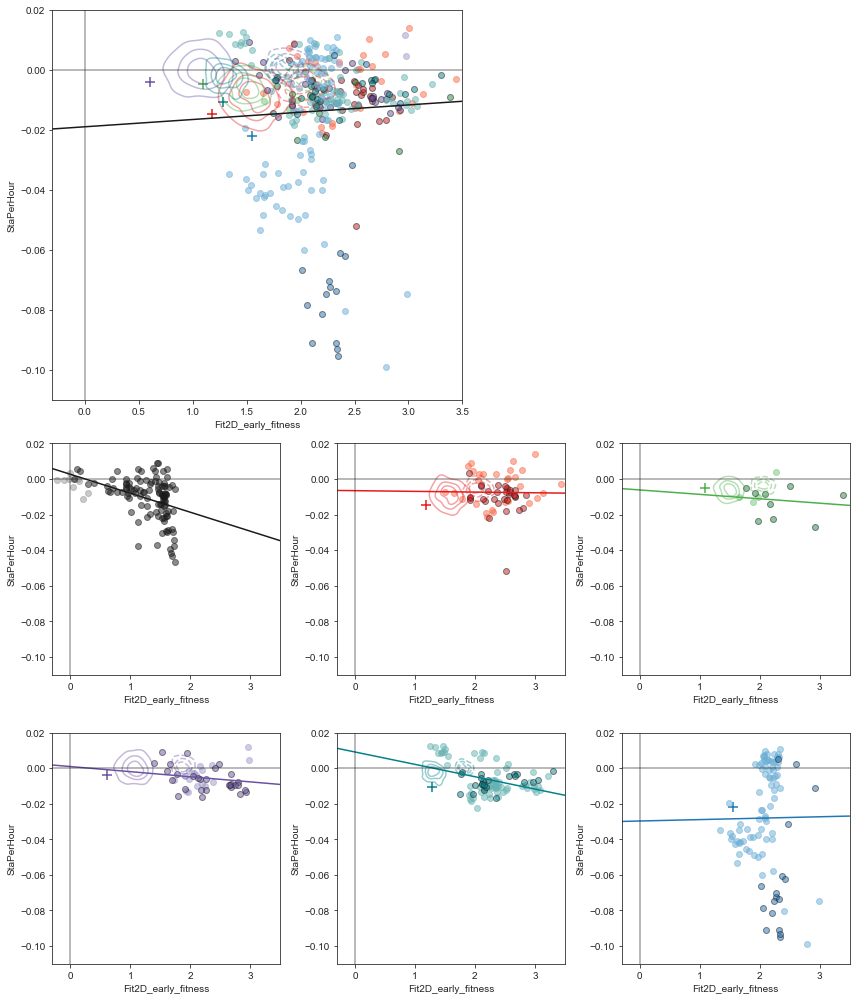

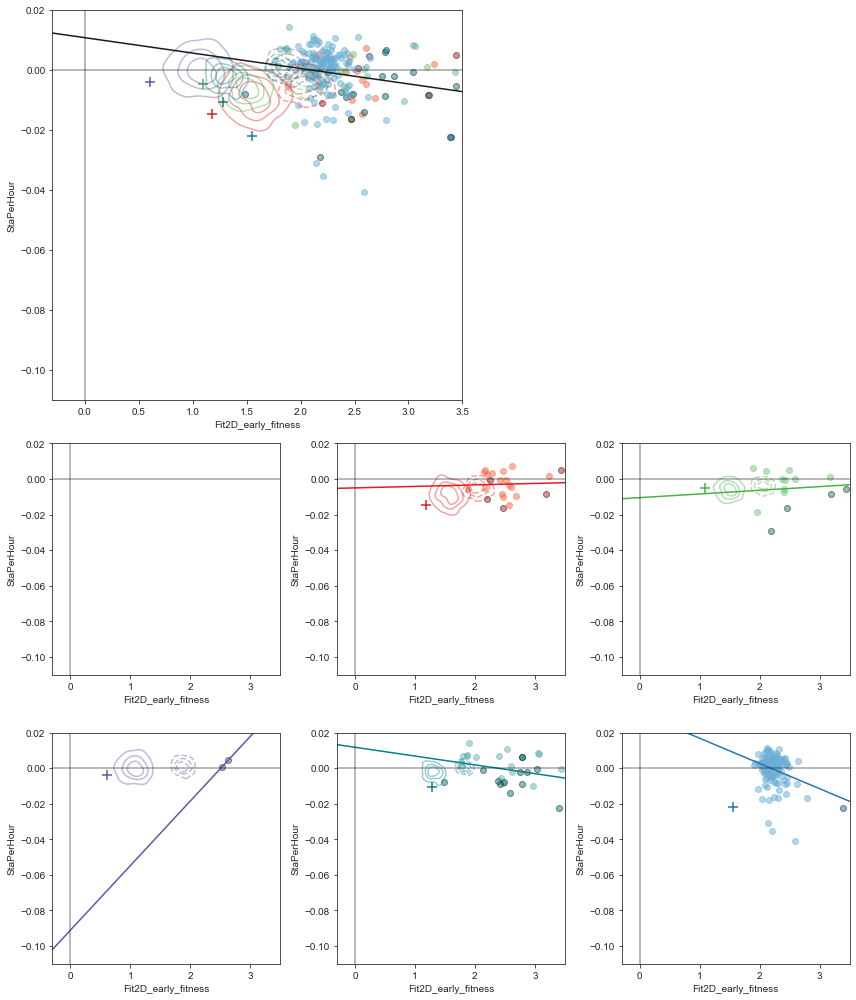

In [142]:
# do mutants that improve both fermentation and respiration have lower stationary performance?

evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]
evo_cond_list = [['Evo2D'],['Evo3D']]
ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

ancestor_list = [['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]



merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 
xdata = 'FerPerHour+ResPerHour'
xdata = 'Fit2D_early_fitness'
ydata = 'StaPerHour'

condition1='FerPerHour'
condition2='ResPerHour'


# merged_fitness['ResPerHour+StaPerHour'] = merged_fitness['ResPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'ResPerHour+StaPerHour'
# ydata = 'FerPerHour'

# merged_fitness['FerPerHour+StaPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'FerPerHour+StaPerHour'
# ydata = 'ResPerHour'
                 
for evo_cond in evo_cond_list:
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,2,2],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        
        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])


        this_anc = merged_fitness

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
        this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

        for anc in ancs:
            
            anc_here = this_data[this_data['ancestor']==anc]
            
            if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
            
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
                
                multiplier = 0
                
                if anc != 'IRA1_NON':
                    
                    c1_mean = np.nanmean(this_neutral_haploid[condition1].values)
                    c1_error = np.nanstd(this_neutral_haploid[condition1].values)
                    c2_mean = np.nanmean(this_neutral_haploid[condition2].values)
                    c2_error = np.nanstd(this_neutral_haploid[condition2].values)
                
                    double_improvers = np.where((anc_here[condition1].values > c1_mean+multiplier*c1_error) & 
                                            (anc_here[condition2].values > c2_mean+multiplier*c2_error))
                    
                else:
                    double_improvers = np.where((anc_here[condition1].values > background_mutant[condition1].values+multiplier*background_mutant[condition1+'_error'].values) & 
                                            (anc_here[condition2].values > background_mutant[condition2].values+multiplier*background_mutant[condition2+'_error'].values))
                
                slackers = [ix for ix in range(len(anc_here[condition1].values)) if ix not in double_improvers[0]]
                
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
                
            else:
                double_improvers = np.where((anc_here[condition1].values > 0) & 
                                            (anc_here[condition2].values > 0))
                
                slackers = [ix for ix in range(len(anc_here[condition1].values)) if ix not in double_improvers[0]]
            
#             print(double_improvers[0],slackers)
#             print(anc_here[xdata].values[slackers])
            
            plt.scatter(anc_here[xdata].values[slackers],
                        anc_here[ydata].values[slackers],
                        alpha=0.5,
                        color=tools.anc_evo_cond_color_map[anc]['Evo2D'])
            
            plt.scatter(anc_here[xdata].values[double_improvers[0]],
                        anc_here[ydata].values[double_improvers[0]],
                        alpha=0.5,edgecolors='k',
                        color=tools.anc_evo_cond_color_map[anc]['Evo3D'])
            
            ttest = scipy.stats.ttest_ind(anc_here[ydata].values[double_improvers[0]],anc_here[ydata].values[slackers],equal_var=False)
            print('Double Improvers Different',evo_cond,anc,ttest.pvalue)
            
            if len(ancs) < 2:
                if len(anc_here[xdata].values) > 0:
                    reg = scipy.stats.linregress(x=anc_here[xdata].values
                                                    ,y=anc_here[ydata].values)

                    xs = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                    plt.plot(xs,reg.intercept+reg.slope*xs,color=tools.anc_color_map[anc])
                    print('slope non-zero',evo_cond,anc,reg.slope,reg.pvalue)
                
        if len(ancs) > 1:
            
            anc_here = this_data[this_data['ancestor'].isin(ancs)]
            print('All Second Steps')
            reg = scipy.stats.linregress(x=anc_here[xdata].values
                                            ,y=anc_here[ydata].values)

            xs = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
            plt.plot(xs,reg.intercept+reg.slope*xs,color='k')
            print('All Second Steps','slope non-zero',ancs,len(anc_here),reg.slope,reg.pvalue)
            
            


        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(xdata)
        plt.ylabel(ydata)
#         plt.legend()

        plt.axhline(0,color='k',alpha=0.4)
        plt.axvline(0,color='k',alpha=0.4)

    plt.tight_layout()
                 
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.png',bbox_inches='tight',dpi=300)

['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Ttest_indResult(statistic=-4.330413795471541, pvalue=2.336926162345556e-05)
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS'] Ttest_indResult(statistic=-2.4881712741079074, pvalue=0.013622056587041674)
['CYR1'] Ttest_indResult(statistic=-2.6859381151044, pvalue=0.00934558786222201)
['GPB2'] Ttest_indResult(statistic=-1.305194087400304, pvalue=0.2363265767273824)
['TOR1'] Ttest_indResult(statistic=-1.116648157073077, pvalue=0.2718712899957718)
['IRA1_MIS'] Ttest_indResult(statistic=-0.7862549274994441, pvalue=0.43402355830593387)
['IRA1_NON'] Ttest_indResult(statistic=-4.868248728684146, pvalue=9.127313908015223e-05)


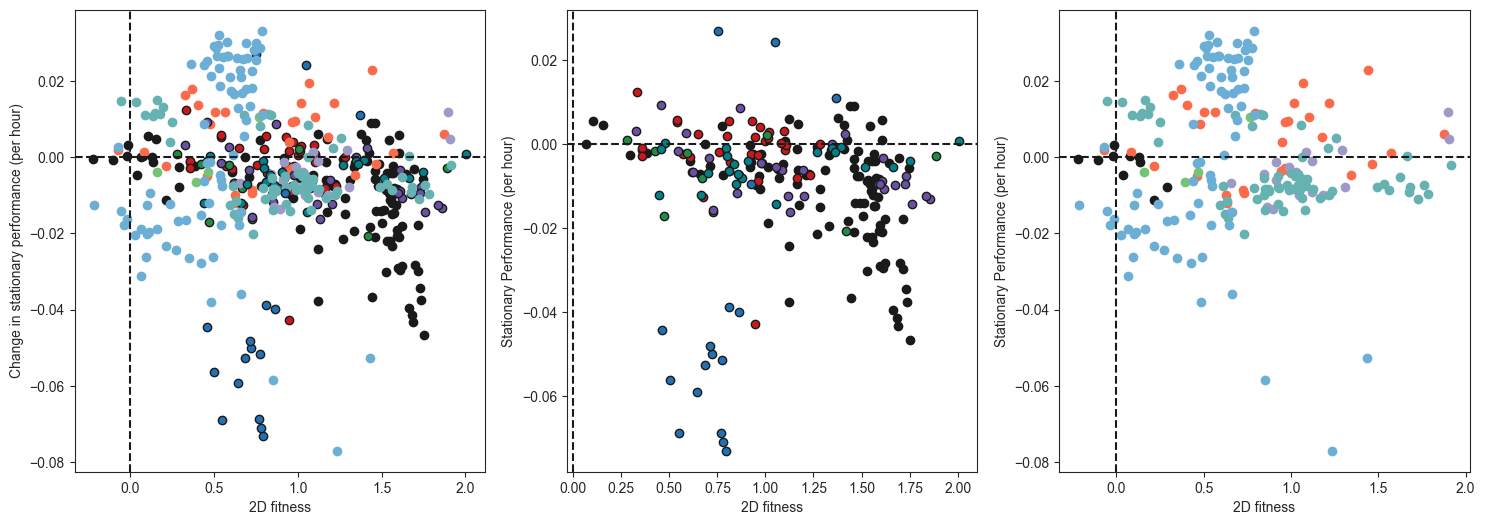

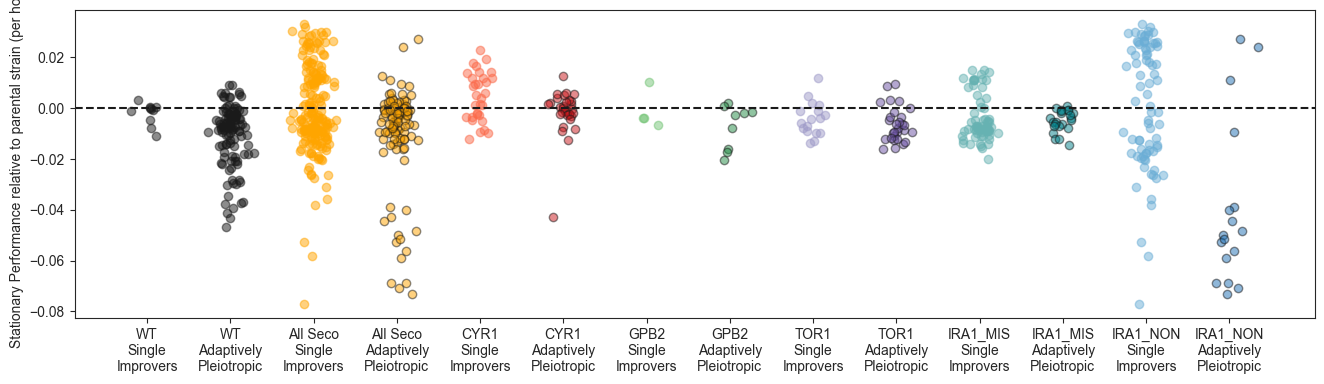

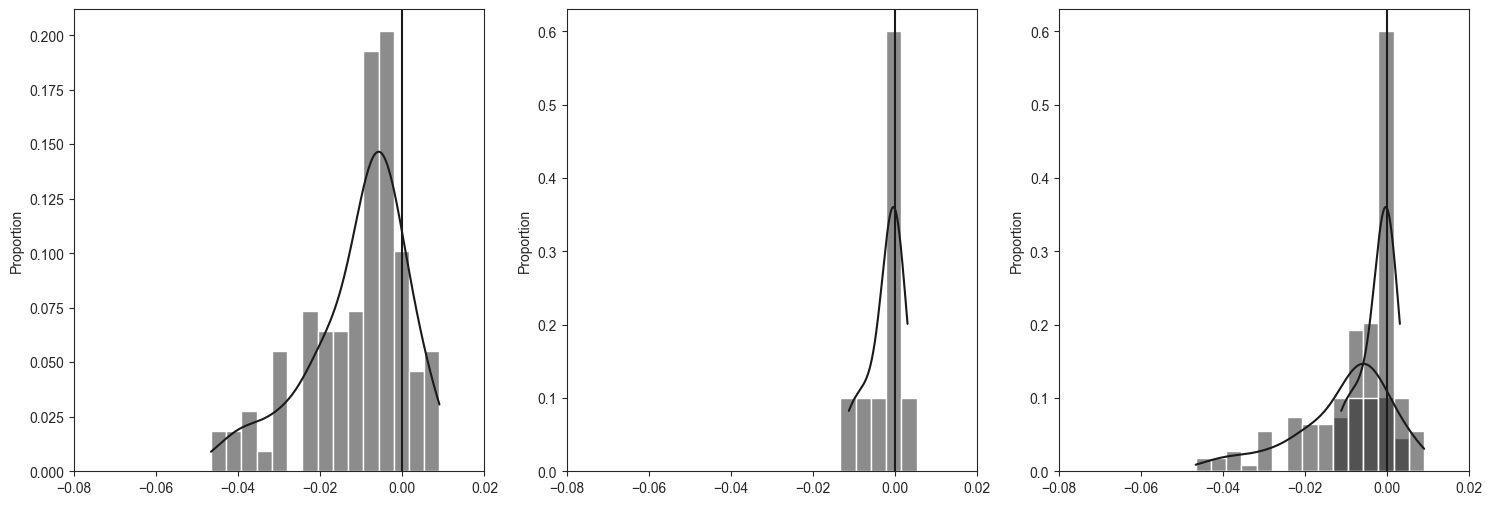

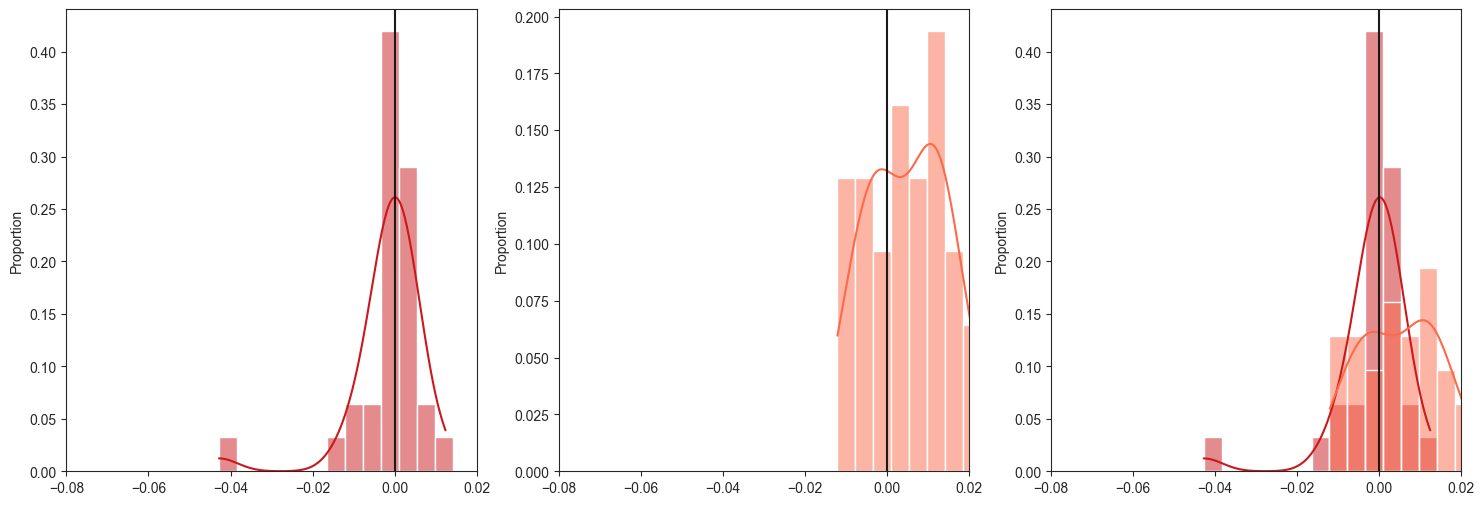

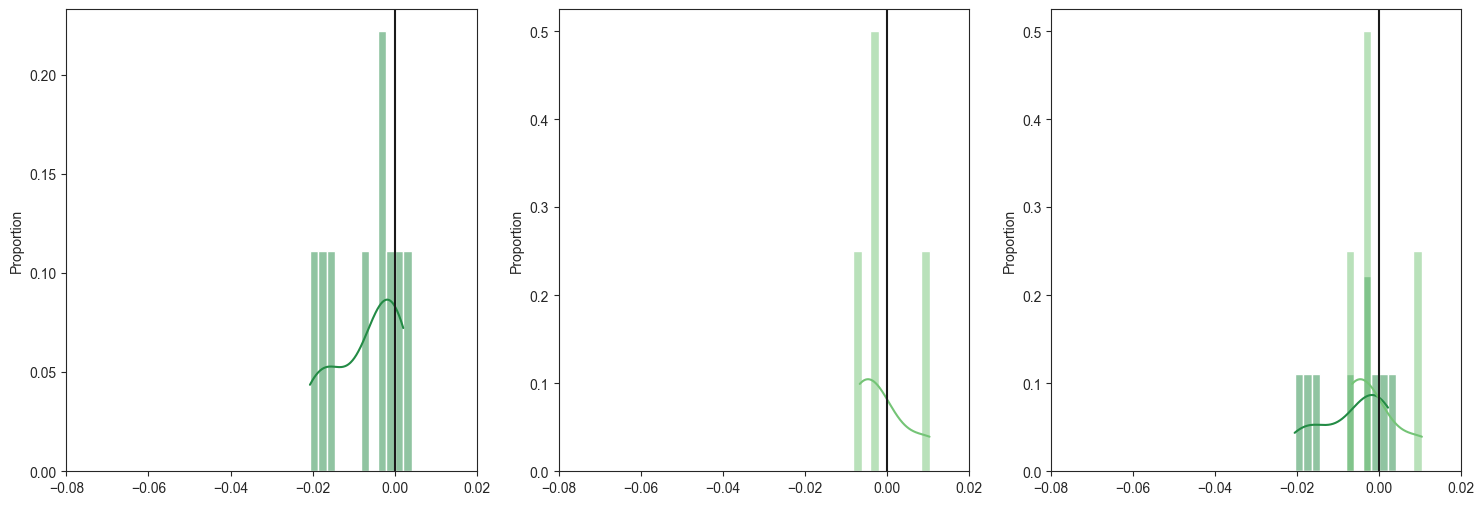

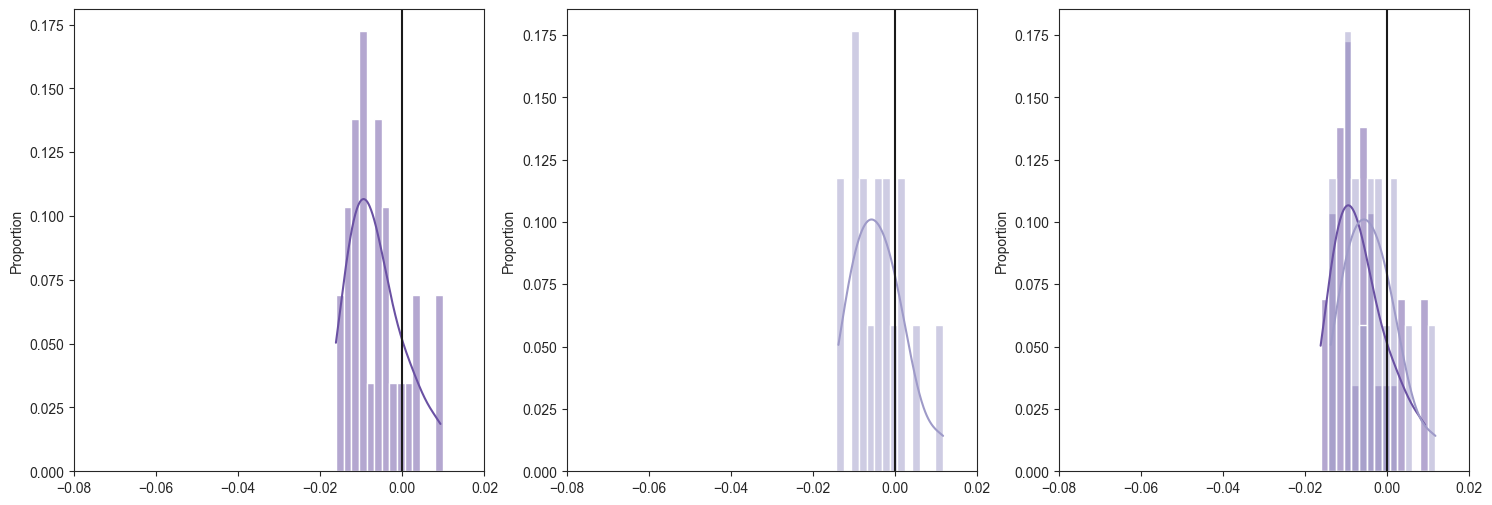

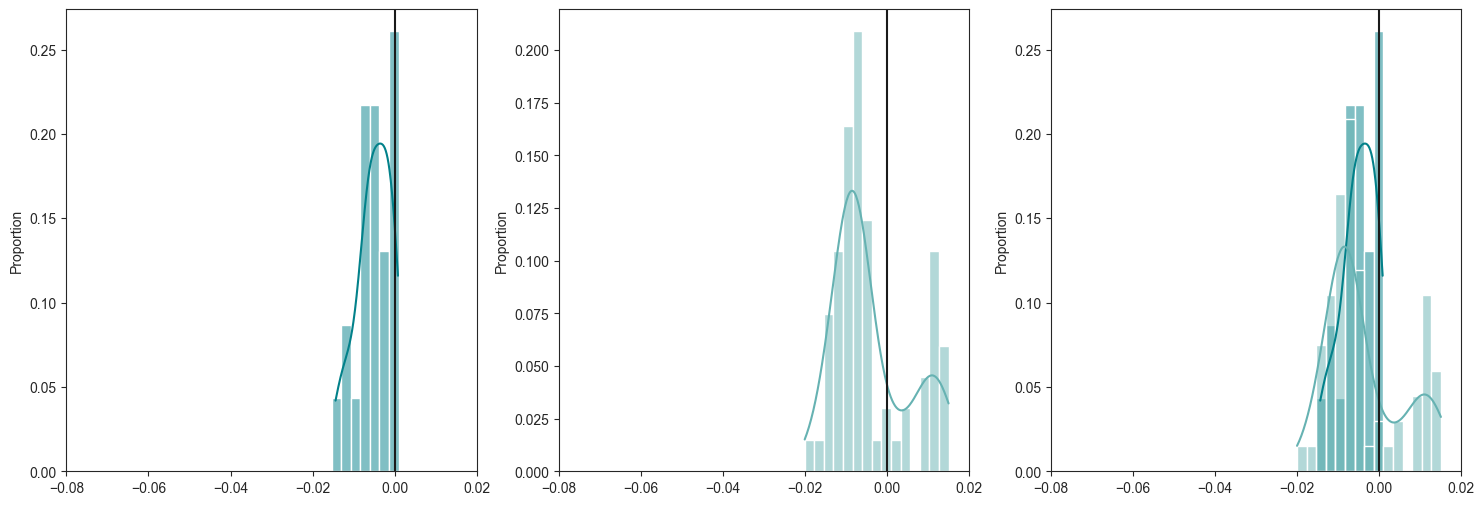

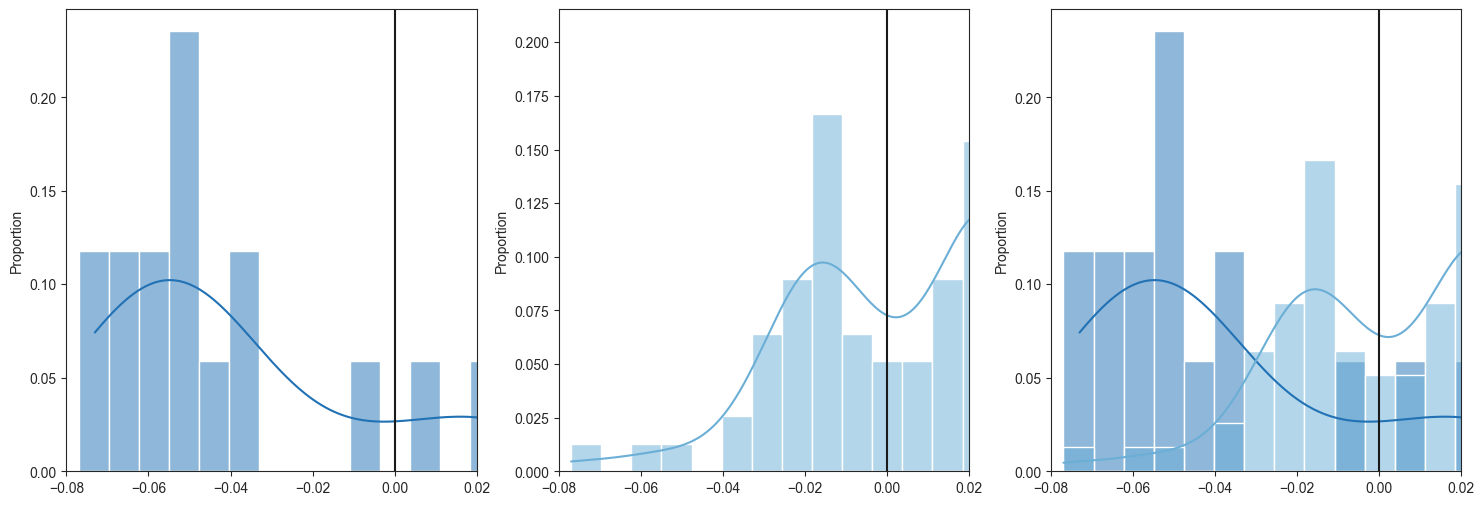

In [7]:
## Figure for all second-step mutants, with change in fitness 

evo_cond = ['Evo2D']

for anc_list in [['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],
                 ['CYR1','GPB2','TOR1','IRA1_MIS'],
                 ['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]:

# this_anc = merged_fitness[merged_fitness['ancestor'].isin(['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'])]
    this_anc = merged_fitness[merged_fitness['ancestor'].isin(anc_list)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

    # plt.scatter(this_data['Fit2D_early_fitness_relative'],this_data['StaPerHour_relative'])

    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                       (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                       (interesting_muts['ResPerHour_relative']>0))]

    # plt.scatter(double_improvers['Fit2D_early_fitness_relative'],double_improvers['StaPerHour_relative'])

    ttest = scipy.stats.ttest_ind(double_improvers['StaPerHour_relative'],slackers['StaPerHour_relative'],equal_var=False)
    print(anc_list,ttest)


anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
# anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS']
fig,axs = plt.subplots(figsize=(6*3,6),ncols=3,nrows=1)
dot_fig,dot_axs = plt.subplots(figsize=(16,4))

all_seconds_slackers = []
all_seconds_doubleimprovers = []
for a,anc  in enumerate(anc_list):
    
    anc_fig,anc_axs = plt.subplots(figsize=(6*3,6),ncols=3,nrows=1,sharex=True)
    
    this_anc = merged_fitness[merged_fitness['ancestor'].isin([anc])]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


    interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    
    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0))]
    
    
    axs[0].scatter(double_improvers['Fit2D_early_fitness_relative'],double_improvers['StaPerHour_relative'],
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],edgecolors='k',)
    axs[0].scatter(slackers['Fit2D_early_fitness_relative'],slackers['StaPerHour_relative'],color=tools.anc_evo_cond_color_map[anc]['Evo2D'])
    axs[1].scatter(double_improvers['Fit2D_early_fitness_relative'],double_improvers['StaPerHour_relative'],
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],edgecolors='k',)
    axs[2].scatter(slackers['Fit2D_early_fitness_relative'],slackers['StaPerHour_relative'],color=tools.anc_evo_cond_color_map[anc]['Evo2D'])
    
    dot_axs.scatter([tools.jitter_point(bool(a)+a+0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values,edgecolors='k',
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],alpha=0.5)
    
    dot_axs.scatter([tools.jitter_point(bool(a)+a,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values,
                   color=tools.anc_evo_cond_color_map[anc]['Evo2D'],alpha=0.5)
    
    if anc != 'WT':
        dot_axs.scatter([tools.jitter_point(1.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values,edgecolors='k',
                   color='orange',alpha=0.5)
        
        dot_axs.scatter([tools.jitter_point(1,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values,
                   color='orange',alpha=0.5)
        
        all_seconds_slackers += list(slackers['StaPerHour_relative'].values)
        all_seconds_doubleimprovers += list(double_improvers['StaPerHour_relative'].values)
#     else:
#         dot_axs.boxplot(slackers['StaPerHour_relative'].values,positions=[0])
#         dot_axs.boxplot(double_improvers['StaPerHour_relative'].values,positions=[0.5])
    
    
    hist,bins = np.histogram(interesting_muts['StaPerHour_relative'].values,bins=15)
    
    sns.histplot(double_improvers['StaPerHour_relative'].values,ax=anc_axs[0],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],stat='proportion',kde=True)
    sns.histplot(slackers['StaPerHour_relative'].values,ax=anc_axs[1],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo2D'],stat='proportion',kde=True)
    
    sns.histplot(double_improvers['StaPerHour_relative'].values,ax=anc_axs[2],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],stat='proportion',kde=True)
    sns.histplot(slackers['StaPerHour_relative'].values,ax=anc_axs[2],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo2D'],stat='proportion',kde=True)
    
    anc_axs[0].set_xlim(-0.08,0.02)
    anc_axs[0].axvline(0,color='k')
    anc_axs[1].axvline(0,color='k')
    anc_axs[2].axvline(0,color='k')
    
    anc_fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/stationary_hists_{anc}.pdf',bbox_inches='tight')

anc_labels = np.insert(anc_list,1,'All Second Step')
dot_axs.set_xticks([a+c*0.5 for c,cl in enumerate(['Single\nImprovers','Adaptively\nPleiotropic']) for a,anc in enumerate(anc_labels) ])
dot_axs.set_xticklabels([f'{anc}\n{cl}' for cl in ['Single\nImprovers','Adaptively\nPleiotropic'] for anc in anc_labels])

# dot_axs.boxplot(all_seconds_slackers,positions=[1],showmeans=True)
# dot_axs.boxplot(all_seconds_doubleimprovers,positions=[1.5],showmeans=True)


axs[0].axhline(0,color='k',linestyle='--')
axs[0].axvline(0,color='k',linestyle='--')
axs[0].set_xlabel('2D fitness')
axs[0].set_ylabel('Change in stationary performance (per hour)')


axs[1].axhline(0,color='k',linestyle='--')
axs[1].axvline(0,color='k',linestyle='--')
axs[1].set_xlabel('2D fitness')
axs[1].set_ylabel('Stationary Performance (per hour)')

axs[2].axhline(0,color='k',linestyle='--')
axs[2].axvline(0,color='k',linestyle='--')
axs[2].set_xlabel('2D fitness')
axs[2].set_ylabel('Stationary Performance (per hour)')

dot_axs.axhline(0,color='k',linestyle='--')
# axs[0].set_xlabel('2D fitness')
dot_axs.set_ylabel('Stationary Performance relative to parental strain (per hour)')

fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy.pdf',bbox_inches='tight')
dot_fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy_dots.pdf',bbox_inches='tight')



['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Ttest_indResult(statistic=-4.330413795471541, pvalue=2.336926162345556e-05)
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS'] Ttest_indResult(statistic=-2.4881712741079074, pvalue=0.013622056587041674)
['CYR1'] Ttest_indResult(statistic=-2.6859381151044, pvalue=0.00934558786222201)
['GPB2'] Ttest_indResult(statistic=-1.305194087400304, pvalue=0.2363265767273824)
['TOR1'] Ttest_indResult(statistic=-1.116648157073077, pvalue=0.2718712899957718)
['IRA1_MIS'] Ttest_indResult(statistic=-0.7862549274994441, pvalue=0.43402355830593387)
['IRA1_NON'] Ttest_indResult(statistic=-4.868248728684146, pvalue=9.127313908015223e-05)


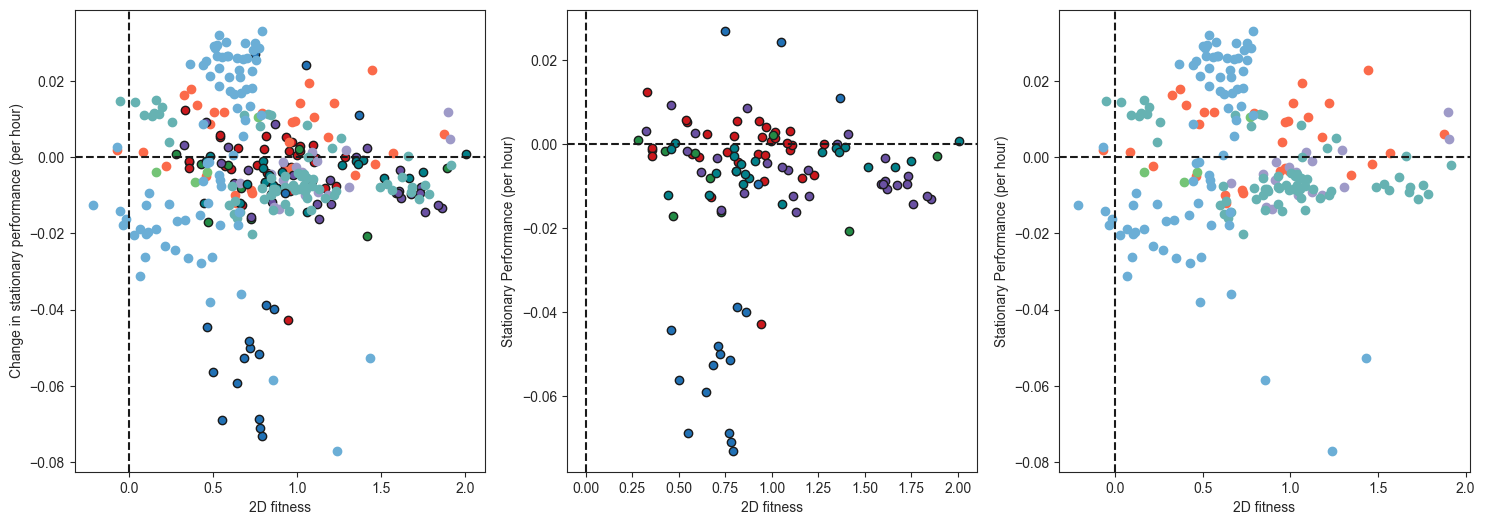

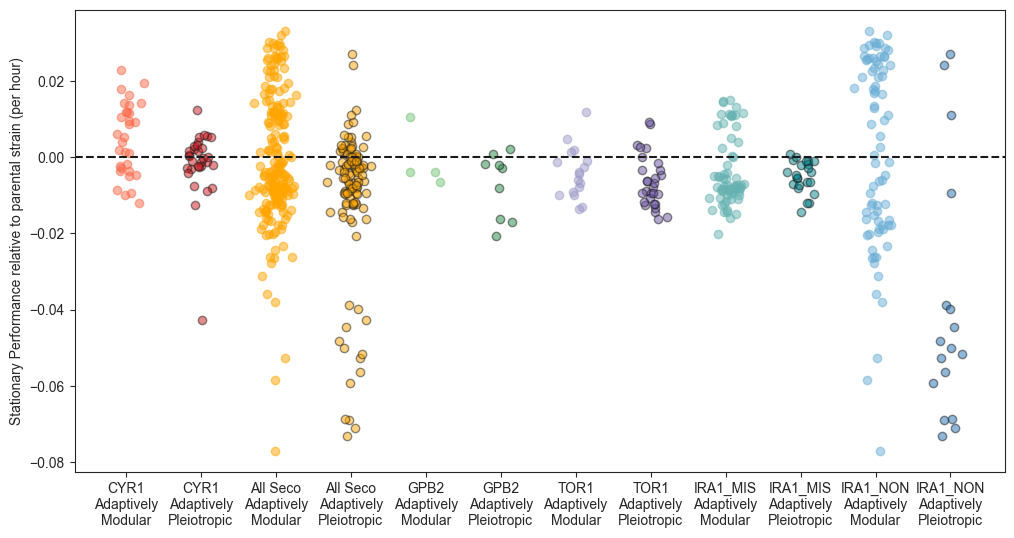

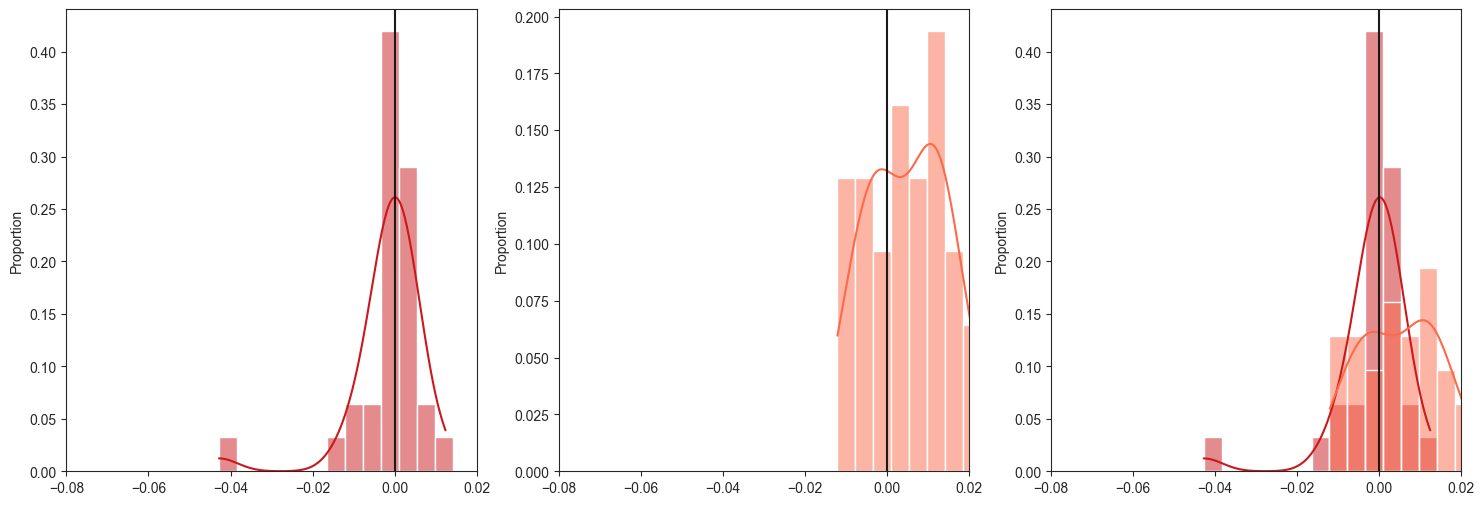

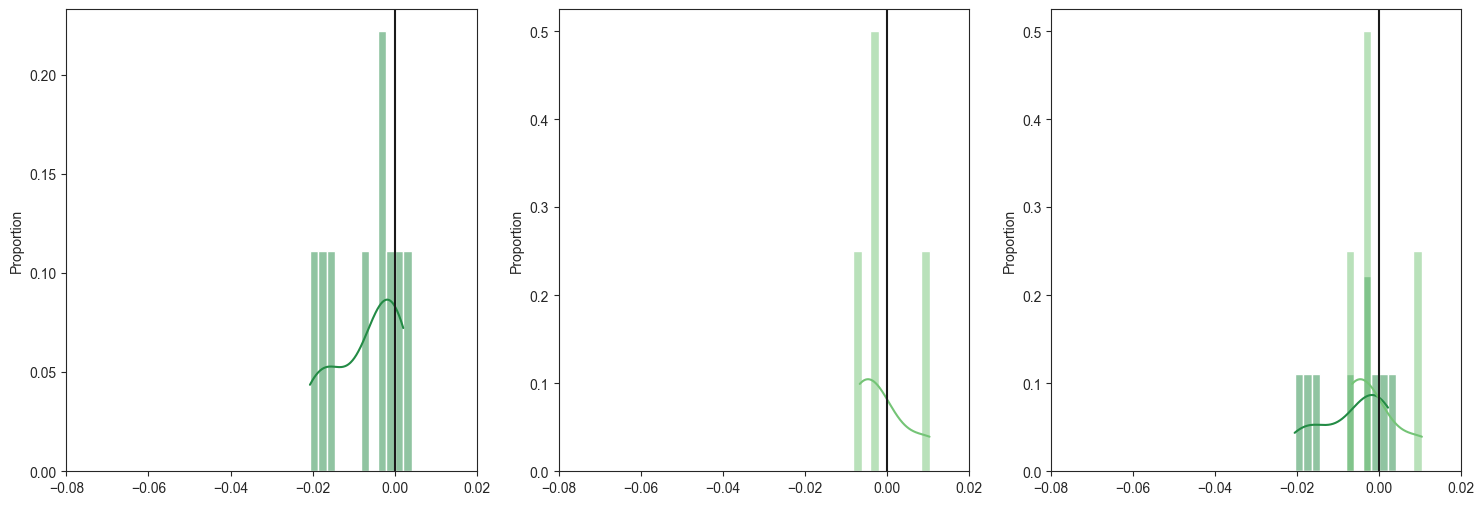

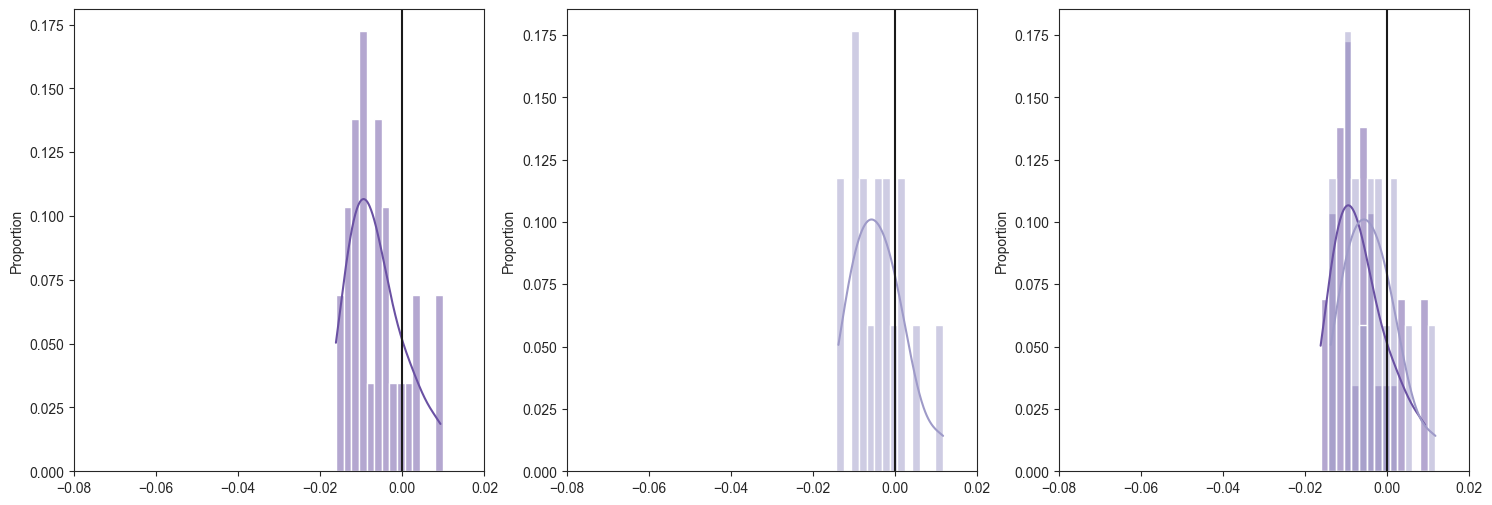

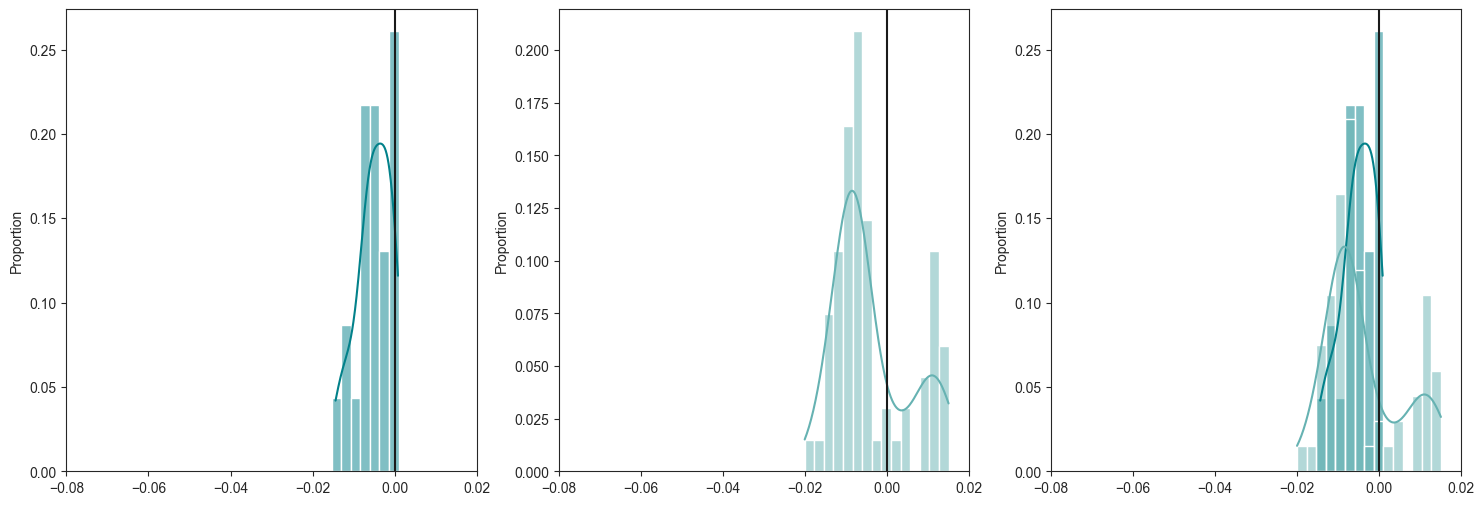

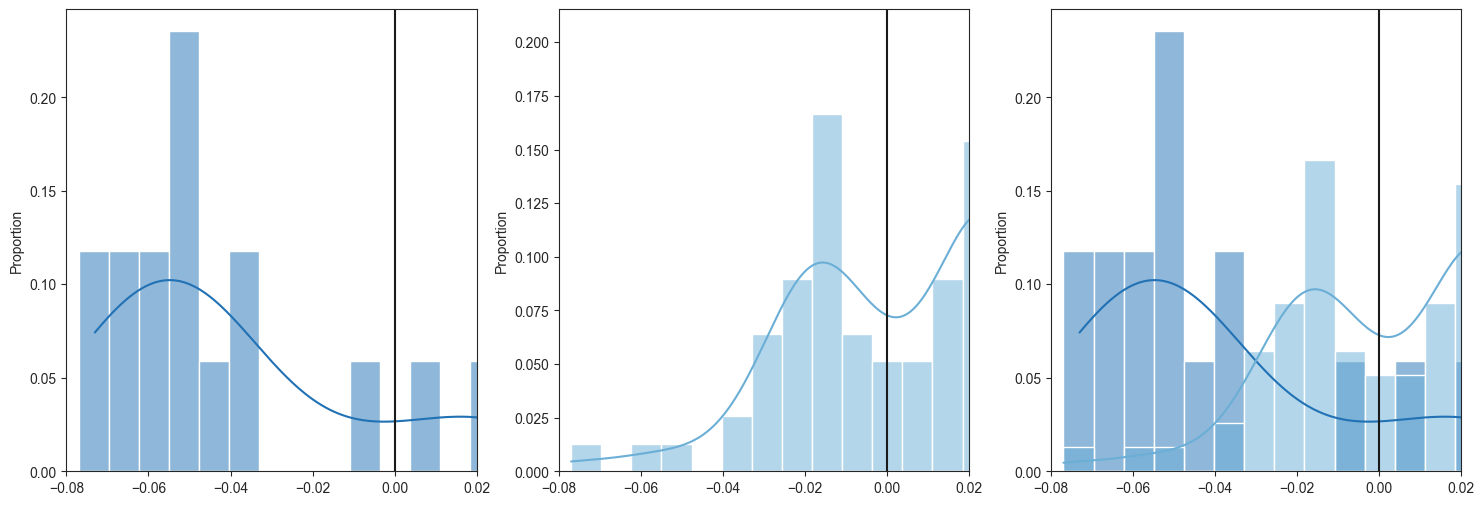

In [8]:
## Figure for all second-step mutants, with change in fitness 

evo_cond = ['Evo2D']

for anc_list in [['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],
                 ['CYR1','GPB2','TOR1','IRA1_MIS'],
                 ['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]:

# this_anc = merged_fitness[merged_fitness['ancestor'].isin(['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'])]
    this_anc = merged_fitness[merged_fitness['ancestor'].isin(anc_list)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

    # plt.scatter(this_data['Fit2D_early_fitness_relative'],this_data['StaPerHour_relative'])

    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                       (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                       (interesting_muts['ResPerHour_relative']>0))]

    # plt.scatter(double_improvers['Fit2D_early_fitness_relative'],double_improvers['StaPerHour_relative'])

    ttest = scipy.stats.ttest_ind(double_improvers['StaPerHour_relative'],slackers['StaPerHour_relative'],equal_var=False)
    print(anc_list,ttest)


# anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
anc_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
# anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS']
fig,axs = plt.subplots(figsize=(6*3,6),ncols=3,nrows=1)
dot_fig,dot_axs = plt.subplots(figsize=(12,6))

all_seconds_slackers = []
all_seconds_doubleimprovers = []
for a,anc  in enumerate(anc_list):
    
    anc_fig,anc_axs = plt.subplots(figsize=(6*3,6),ncols=3,nrows=1,sharex=True)
    
    this_anc = merged_fitness[merged_fitness['ancestor'].isin([anc])]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


    interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    
    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0))]
    
    
    axs[0].scatter(double_improvers['Fit2D_early_fitness_relative'],double_improvers['StaPerHour_relative'],
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],edgecolors='k',)
    axs[0].scatter(slackers['Fit2D_early_fitness_relative'],slackers['StaPerHour_relative'],color=tools.anc_evo_cond_color_map[anc]['Evo2D'])
    axs[1].scatter(double_improvers['Fit2D_early_fitness_relative'],double_improvers['StaPerHour_relative'],
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],edgecolors='k',)
    axs[2].scatter(slackers['Fit2D_early_fitness_relative'],slackers['StaPerHour_relative'],color=tools.anc_evo_cond_color_map[anc]['Evo2D'])
    
    dot_axs.scatter([tools.jitter_point(bool(a)+a+0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values,edgecolors='k',
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],alpha=0.5)
    
    dot_axs.scatter([tools.jitter_point(bool(a)+a,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values,
                   color=tools.anc_evo_cond_color_map[anc]['Evo2D'],alpha=0.5)
    
    if anc != 'WT':
        dot_axs.scatter([tools.jitter_point(1.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values,edgecolors='k',
                   color='orange',alpha=0.5)
        
        dot_axs.scatter([tools.jitter_point(1,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values,
                   color='orange',alpha=0.5)
        
        all_seconds_slackers += list(slackers['StaPerHour_relative'].values)
        all_seconds_doubleimprovers += list(double_improvers['StaPerHour_relative'].values)
#     else:
#         dot_axs.boxplot(slackers['StaPerHour_relative'].values,positions=[0])
#         dot_axs.boxplot(double_improvers['StaPerHour_relative'].values,positions=[0.5])
    
    
    hist,bins = np.histogram(interesting_muts['StaPerHour_relative'].values,bins=15)
    
    sns.histplot(double_improvers['StaPerHour_relative'].values,ax=anc_axs[0],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],stat='proportion',kde=True)
    sns.histplot(slackers['StaPerHour_relative'].values,ax=anc_axs[1],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo2D'],stat='proportion',kde=True)
    
    sns.histplot(double_improvers['StaPerHour_relative'].values,ax=anc_axs[2],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],stat='proportion',kde=True)
    sns.histplot(slackers['StaPerHour_relative'].values,ax=anc_axs[2],bins=bins,
                   color=tools.anc_evo_cond_color_map[anc]['Evo2D'],stat='proportion',kde=True)
    
    anc_axs[0].set_xlim(-0.08,0.02)
    anc_axs[0].axvline(0,color='k')
    anc_axs[1].axvline(0,color='k')
    anc_axs[2].axvline(0,color='k')
    
    anc_fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/stationary_hists_{anc}.pdf',bbox_inches='tight')

anc_labels = np.insert(anc_list,1,'All Second Step')
dot_axs.set_xticks([a+c*0.5 for c,cl in enumerate(['Adaptively\nModular','Adaptively\nPleiotropic']) for a,anc in enumerate(anc_labels) ])
dot_axs.set_xticklabels([f'{anc}\n{cl}' for cl in ['Adaptively\nModular','Adaptively\nPleiotropic'] for anc in anc_labels])

# dot_axs.boxplot(all_seconds_slackers,positions=[1],showmeans=True)
# dot_axs.boxplot(all_seconds_doubleimprovers,positions=[1.5],showmeans=True)


axs[0].axhline(0,color='k',linestyle='--')
axs[0].axvline(0,color='k',linestyle='--')
axs[0].set_xlabel('2D fitness')
axs[0].set_ylabel('Change in stationary performance (per hour)')


axs[1].axhline(0,color='k',linestyle='--')
axs[1].axvline(0,color='k',linestyle='--')
axs[1].set_xlabel('2D fitness')
axs[1].set_ylabel('Stationary Performance (per hour)')

axs[2].axhline(0,color='k',linestyle='--')
axs[2].axvline(0,color='k',linestyle='--')
axs[2].set_xlabel('2D fitness')
axs[2].set_ylabel('Stationary Performance (per hour)')

dot_axs.axhline(0,color='k',linestyle='--')
# axs[0].set_xlabel('2D fitness')
dot_axs.set_ylabel('Stationary Performance relative to parental strain (per hour)')

fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy.pdf',bbox_inches='tight')
dot_fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy_dots.pdf',bbox_inches='tight')




['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Ttest_indResult(statistic=-4.330413795471541, pvalue=2.336926162345556e-05)
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS'] Ttest_indResult(statistic=-2.4881712741079074, pvalue=0.013622056587041674)
['CYR1'] Ttest_indResult(statistic=-2.6859381151044, pvalue=0.00934558786222201)
['GPB2'] Ttest_indResult(statistic=-1.305194087400304, pvalue=0.2363265767273824)
['TOR1'] Ttest_indResult(statistic=-1.116648157073077, pvalue=0.2718712899957718)
['IRA1_MIS'] Ttest_indResult(statistic=-0.7862549274994441, pvalue=0.43402355830593387)
['IRA1_NON'] Ttest_indResult(statistic=-4.868248728684146, pvalue=9.127313908015223e-05)


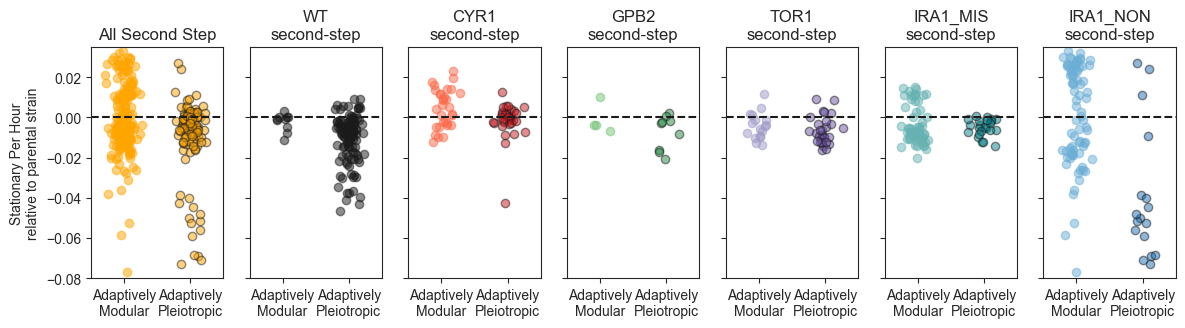

In [7]:
## Figure for all second-step mutants, with change in fitness 

evo_cond = ['Evo2D']

for anc_list in [['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],
                 ['CYR1','GPB2','TOR1','IRA1_MIS'],
                 ['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]:

# this_anc = merged_fitness[merged_fitness['ancestor'].isin(['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'])]
    this_anc = merged_fitness[merged_fitness['ancestor'].isin(anc_list)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

    # plt.scatter(this_data['Fit2D_early_fitness_relative'],this_data['StaPerHour_relative'])

    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                       (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                       (interesting_muts['ResPerHour_relative']>0))]

    # plt.scatter(double_improvers['Fit2D_early_fitness_relative'],double_improvers['StaPerHour_relative'])

    ttest = scipy.stats.ttest_ind(double_improvers['StaPerHour_relative'],slackers['StaPerHour_relative'],equal_var=False)
    print(anc_list,ttest)


anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
# anc_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
# anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS']
# fig,axs = plt.subplots(figsize=(6*3,6),ncols=3,nrows=1)
dot_fig,dot_axs = plt.subplots(figsize=((len(anc_list)+1)*2,3),ncols=len(anc_list)+1,sharey=True)

all_seconds_slackers = []
all_seconds_doubleimprovers = []
for a,anc in enumerate(anc_list):
    
    this_anc = merged_fitness[merged_fitness['ancestor'].isin([anc])]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


    interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
    
    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0))]
    

    dot_axs[a+1].scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values,edgecolors='k',
                   color=tools.anc_evo_cond_color_map[anc]['Evo3D'],alpha=0.5)
    
    dot_axs[a+1].scatter([tools.jitter_point(0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values,
                   color=tools.anc_evo_cond_color_map[anc]['Evo2D'],alpha=0.5)
    
    
    dot_axs[a+1].set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
#     dot_axs[a+1].set_xticklabels([f'{anc}\n{cl}' for cl in ['Adaptively\nModular','Adaptively\nPleiotropic'] for anc in anc_labels])

    dot_axs[a+1].set_ylim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
    dot_axs[a+1].set_xlim(-0.25,0.75)
    plt.sca(dot_axs[a+1])
    plt.axhline(0,color='k',linestyle='--')
    
    plt.title(f'{anc}\nsecond-step')
    
    if anc != 'WT':
        dot_axs[0].scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values,edgecolors='k',
                   color='orange',alpha=0.5)
        
        dot_axs[0].scatter([tools.jitter_point(0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values,
                   color='orange',alpha=0.5)
        
        if anc == anc_list[-1]:
            plt.sca(dot_axs[0])
            dot_axs[0].set_xlim(-0.25,0.75)
    #         plt.sca(dot_axs[a+1])
            plt.axhline(0,color='k',linestyle='--')
            dot_axs[0].set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
            plt.title('All Second Step')
        

plt.ylabel('Stationary Per Hour\nrelative to parental strain')
# fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy.pdf',bbox_inches='tight')
dot_fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy_dots.pdf',bbox_inches='tight')





['WT'] Evo2D
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo2D
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo3D


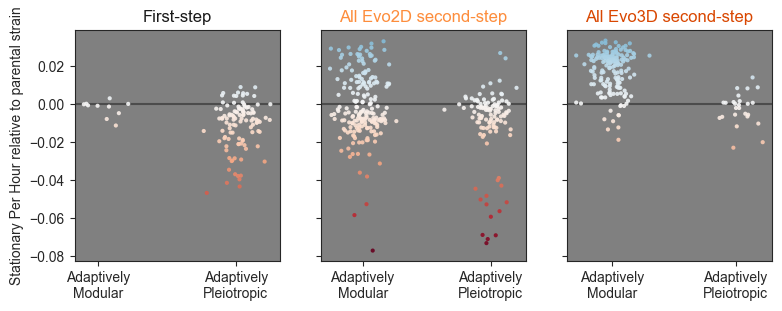

In [25]:
## Figure for all second-step mutants, with change in fitness 

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

dot_fig,dot_axs = plt.subplots(figsize=(9,3),ncols=6,sharey=True)

ancestor_evo_list = [(['WT'],'Evo2D'),
                         (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo2D'),
                        (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo3D')]

names = ['First-step','All Evo2D second-step','All Evo3D second-step']

fitness_colorby = 'StaPerHour_relative'

for a,anc_evo in enumerate(ancestor_evo_list):
    
    ancs = anc_evo[0]
    evo_cond = anc_evo[1]

    print(ancs,evo_cond)

    this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    this_data = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    
    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0))]
    
    if len(ancs) > 2:
        color_here = tools.anc_evo_cond_color_map['all_second_step'][evo_cond]
    else:
        color_here = tools.anc_evo_cond_color_map['WT'][evo_cond]
        
        
    normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(noLi2019[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(noLi2019[fitness_colorby]).max())
        
    sorting_order = np.argsort(double_improvers[fitness_colorby].values)[::-1]
#         sorting_order = np.argsort(this_data[fitness_colorby].values)
    
    dot_axs[a].set_facecolor('gray')
    dot_axs[a].scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values[sorting_order],
                        c=double_improvers[fitness_colorby].values[sorting_order],cmap='RdBu',
                        norm=normalize,
                        marker='.',
                        alpha=0.9,linewidths=0)
    
    sorting_order = np.argsort(slackers[fitness_colorby].values)[::-1]
    
    dot_axs[a].scatter([tools.jitter_point(0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values[sorting_order],
                        c=slackers[fitness_colorby].values[sorting_order],cmap='RdBu',
                        norm=normalize,
                        marker='.',
                        alpha=0.9,linewidths=0)
    
#     dot_axs[a].scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
#                    double_improvers['StaPerHour_relative'].values,edgecolors='k',
#                    color=color_here,alpha=0.4)
    
#     dot_axs[a].scatter([tools.jitter_point(0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
#                    slackers['StaPerHour_relative'].values,
#                    color=color_here,alpha=0.4)
    plt.sca(dot_axs[a])
    
    plt.axhline(0,color='k',linestyle='-',alpha=0.5,zorder=0)
    if len(ancs) > 1:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['all_second_step'][evo_cond]})
    else:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['WT'][evo_cond]})
    
    if len(ancs) < 2:
        plt.ylabel('Stationary Per Hour relative to parental strain')
#     plt.xlabel()
    
    
    dot_axs[a].set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
#     dot_axs[a].set_xticklabels([f'{anc}\n{cl}' for cl in ['Adaptively\nModular','Adaptively\nPleiotropic'] for anc in anc_labels])

#     dot_axs[a+1].set_ylim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
#     dot_axs[a+1].set_xlim(-0.25,0.75)
#     plt.sca(dot_axs[a+1])
#     plt.axhline(0,color='k',linestyle='--')
    
#     plt.title(f'{anc}\nsecond-step')
    
#     if anc != 'WT':
#         dot_axs[0].scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
#                    double_improvers['StaPerHour_relative'].values,edgecolors='k',
#                    color='orange',alpha=0.5)
        
#         dot_axs[0].scatter([tools.jitter_point(0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
#                    slackers['StaPerHour_relative'].values,
#                    color='orange',alpha=0.5)
        
#         if anc == anc_list[-1]:
#             plt.sca(dot_axs[0])
#             dot_axs[0].set_xlim(-0.25,0.75)
#     #         plt.sca(dot_axs[a+1])
#             plt.axhline(0,color='k',linestyle='--')
#             dot_axs[0].set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
#             plt.title('All Second Step')
        

# plt.ylabel('Stationary Per Hour\nrelative to parental strain')
# # fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy.pdf',bbox_inches='tight')
dot_fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/AllSecondStep_byAP_StaPerHourColors.pdf',bbox_inches='tight')






['WT'] Evo2D
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo2D
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo3D


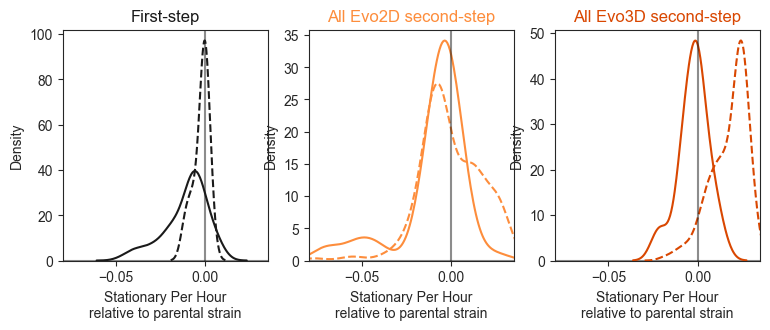

In [45]:
## Figure for all second-step mutants, with change in fitness 

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

dot_fig,dot_axs = plt.subplots(figsize=(9,3),ncols=3)


ancestor_evo_list = [(['WT'],'Evo2D'),
                         (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo2D'),
                        (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo3D')]

names = ['First-step','All Evo2D second-step','All Evo3D second-step']

fitness_colorby = 'StaPerHour_relative'

for a,anc_evo in enumerate(ancestor_evo_list):
    
    ancs = anc_evo[0]
    evo_cond = anc_evo[1]

    print(ancs,evo_cond)

    this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    this_data = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    
    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0))]
    
    if len(ancs) > 2:
        color_here = tools.anc_evo_cond_color_map['all_second_step'][evo_cond]
    else:
        color_here = tools.anc_evo_cond_color_map['WT'][evo_cond]
        
    hist,bins = np.histogram(interesting_muts['StaPerHour_relative'].values)
    
#     sns.histplot(double_improvers['StaPerHour_relative'].values,ax=dot_axs[a],bins=bins,
#                    color='k',stat='count',kde=True)
#     sns.histplot(slackers['StaPerHour_relative'].values,ax=dot_axs[a],bins=bins,
#                    color='gray',stat='count',kde=True)

    
    sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=dot_axs[a],
                   color=color_here,linestyle='-')
#     sns.rugplot(double_improvers['StaPerHour_relative'].values,color=color_here,ax=dot_axs[a])
    
    sns.kdeplot(slackers['StaPerHour_relative'].values,ax=dot_axs[a],
                   color=color_here,linestyle='--')
#     sns.rugplot(slackers['StaPerHour_relative'].values,color=color_here,ax=dot_axs[a])
    
    

    plt.sca(dot_axs[a])
    plt.xlim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
    
    plt.axhline(0,color='k',linestyle='-',alpha=0.5,zorder=0)
    if len(ancs) > 1:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['all_second_step'][evo_cond]})
    else:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['WT'][evo_cond]})
        
    plt.xlabel('Stationary Per Hour\nrelative to parental strain')
    plt.axvline(0,color='k',linestyle='-',alpha=0.5)
    
#     plt.xlabel()
    
    
#     dot_axs[a].set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
#     dot_axs[a].set_xticklabels([f'{anc}\n{cl}' for cl in ['Adaptively\nModular','Adaptively\nPleiotropic'] for anc in anc_labels])

#     dot_axs[a+1].set_ylim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
#     dot_axs[a+1].set_xlim(-0.25,0.75)
#     plt.sca(dot_axs[a+1])
#     plt.axhline(0,color='k',linestyle='--')
    
#     plt.title(f'{anc}\nsecond-step')
    
#     if anc != 'WT':
#         dot_axs[0].scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
#                    double_improvers['StaPerHour_relative'].values,edgecolors='k',
#                    color='orange',alpha=0.5)
        
#         dot_axs[0].scatter([tools.jitter_point(0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
#                    slackers['StaPerHour_relative'].values,
#                    color='orange',alpha=0.5)
        
#         if anc == anc_list[-1]:
#             plt.sca(dot_axs[0])
#             dot_axs[0].set_xlim(-0.25,0.75)
#     #         plt.sca(dot_axs[a+1])
#             plt.axhline(0,color='k',linestyle='--')
#             dot_axs[0].set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
#             plt.title('All Second Step')
        

# 
# # fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/second_step_by_adaptive_pleiotropy.pdf',bbox_inches='tight')
dot_fig.savefig(f'{home_dir}/figures/analysis/stationary_effect/AllSecondStep_byAP_kdes.pdf',bbox_inches='tight')







['WT'] Evo2D
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo2D


/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_67233/3054231648.py:95: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_67233/3054231648.py:99: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(slackers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_67233/3054231648.py:95: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_67233/3054231648.py:99: U

['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo3D


/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_67233/3054231648.py:95: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_67233/3054231648.py:99: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(slackers['StaPerHour_relative'].values,ax=plt.gca(),


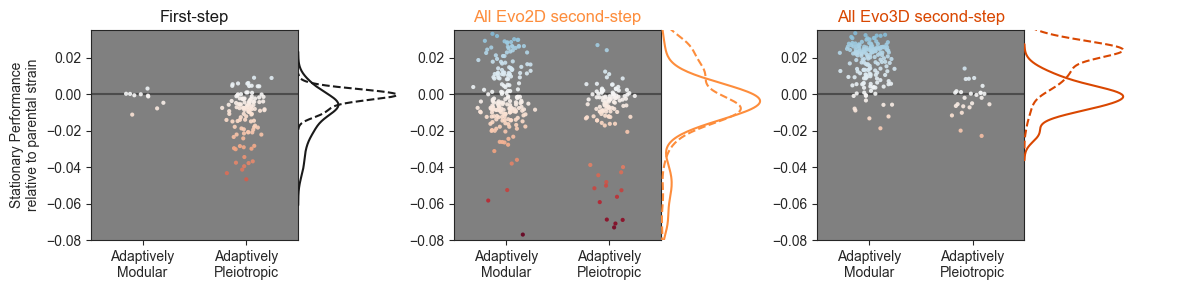

In [83]:
## Figure for all second-step mutants, with change in fitness 

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

# dot_fig,dot_axs = plt.subplots(figsize=(12,3),ncols=6)

fig = plt.figure(figsize=(12,3))
dot_width = 1
density_width = 0.5
empty_width=0.25
gs = gridspec.GridSpec(1,9,width_ratios=[dot_width,density_width,empty_width,
                                         dot_width,density_width,empty_width,
                                         dot_width,density_width,empty_width],wspace=0)

ancestor_evo_list = [(['WT'],'Evo2D'),
                         (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo2D'),
                        (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo3D')]

names = ['First-step','All Evo2D second-step','All Evo3D second-step']

fitness_colorby = 'StaPerHour_relative'

for a,anc_evo in enumerate(ancestor_evo_list):
    
    ancs = anc_evo[0]
    evo_cond = anc_evo[1]
    
    fig.add_subplot(gs[3*a])

    print(ancs,evo_cond)

    this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    this_data = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    
    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0))]
    
    if len(ancs) > 2:
        color_here = tools.anc_evo_cond_color_map['all_second_step'][evo_cond]
    else:
        color_here = tools.anc_evo_cond_color_map['WT'][evo_cond]
        
        
    normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(noLi2019[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(noLi2019[fitness_colorby]).max())
        
    sorting_order = np.argsort(double_improvers[fitness_colorby].values)[::-1]
#         sorting_order = np.argsort(this_data[fitness_colorby].values)
    
    plt.gca().set_facecolor('gray')
    plt.scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values[sorting_order],
                        c=double_improvers[fitness_colorby].values[sorting_order],cmap='RdBu',
                        norm=normalize,
                        marker='.',
                        alpha=0.9,linewidths=0)
    
    sorting_order = np.argsort(slackers[fitness_colorby].values)[::-1]
    
    plt.scatter([tools.jitter_point(0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values[sorting_order],
                        c=slackers[fitness_colorby].values[sorting_order],cmap='RdBu',
                        norm=normalize,
                        marker='.',
                        alpha=0.9,linewidths=0)
    
    
    plt.ylim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
    plt.gca().set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
    
    plt.axhline(0,color='k',linestyle='-',alpha=0.5,zorder=0)
    
    if len(ancs) > 1:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['all_second_step'][evo_cond]})
    else:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['WT'][evo_cond]})
        plt.ylabel('Stationary Performance\nrelative to parental strain')
        
    plt.xlim(-0.25,0.75)
        
        
    fig.add_subplot(gs[3*a+1])
    
    sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
                   color=color_here,linestyle='-',vertical=True)

    
    sns.kdeplot(slackers['StaPerHour_relative'].values,ax=plt.gca(),
                   color=color_here,linestyle='--',vertical=True)

    plt.ylim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
    plt.axis('off')
    
    
    fig.add_subplot(gs[3*a+2])
    plt.axis('off')
    
plt.tight_layout()
plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/AllSecondStep_byAP_dots_density.pdf',bbox_inches='tight')







['WT'] Evo2D
ALL MUTANTS
2 36 81 119
Above 0.01680672268907563
Below 0.3025210084033613
Adaptively pleiotropic
2 36 71 109
Above 0.01834862385321101
Below 0.3302752293577982
Adaptively modular
0 0 10 10
Above 0.0
Below 0.0
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo2D
ALL MUTANTS
77 129 100 306
Above 0.25163398692810457
Below 0.4215686274509804
Adaptively pleiotropic
7 53 49 109
Above 0.06422018348623854
Below 0.48623853211009177
Adaptively modular
70 76 51 197
Above 0.3553299492385787
Below 0.38578680203045684
['CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'] Evo3D


/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_8309/3144535541.py:161: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_8309/3144535541.py:165: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(slackers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_8309/3144535541.py:161: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_8309/3144535541.py:165: U

ALL MUTANTS
160 15 27 202
Above 0.7920792079207921
Below 0.07425742574257425
Adaptively pleiotropic
5 10 10 25
Above 0.2
Below 0.4
Adaptively modular
155 5 17 177
Above 0.8757062146892656
Below 0.02824858757062147


/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_8309/3144535541.py:161: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_8309/3144535541.py:165: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(slackers['StaPerHour_relative'].values,ax=plt.gca(),


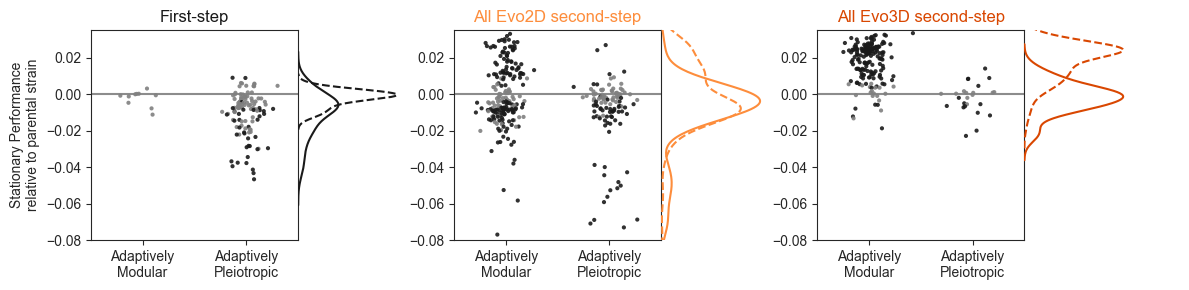

In [7]:
## Figure for all second-step mutants, with change in fitness 

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

# dot_fig,dot_axs = plt.subplots(figsize=(12,3),ncols=6)

fig = plt.figure(figsize=(12,3))
dot_width = 1
density_width = 0.5
empty_width=0.25
gs = gridspec.GridSpec(1,9,width_ratios=[dot_width,density_width,empty_width,
                                         dot_width,density_width,empty_width,
                                         dot_width,density_width,empty_width],wspace=0)

ancestor_evo_list = [(['WT'],'Evo2D'),
                         (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo2D'),
                        (['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],'Evo3D')]

names = ['First-step','All Evo2D second-step','All Evo3D second-step']

fitness_colorby = 'StaPerHour_relative'

for a,anc_evo in enumerate(ancestor_evo_list):
    
    ancs = anc_evo[0]
    evo_cond = anc_evo[1]
    
    fig.add_subplot(gs[3*a])

    print(ancs,evo_cond)

    this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

    interesting_muts = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    this_data = interesting_muts[interesting_muts['evolution_condition'] == evo_cond]
    
    double_improvers = interesting_muts[(interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0)]

    slackers = interesting_muts[~((interesting_muts['FerPerHour_relative']>0) & 
                                   (interesting_muts['ResPerHour_relative']>0))]
    
    if len(ancs) > 2:
        color_here = tools.anc_evo_cond_color_map['all_second_step'][evo_cond]
    else:
        color_here = tools.anc_evo_cond_color_map['WT'][evo_cond]
        
    
    multiplier = 1.0
    color_list = []
    above = 0
    below = 0
    same = 0
    for perf,error in zip(interesting_muts['StaPerHour_relative'].values,
                         interesting_muts['StaPerHour_error'].values):
        if perf-multiplier*error > 0:
            color_list.append('k')
            above += 1
        elif perf+multiplier*error < 0:
            color_list.append('k')
            below += 1
        else:
            color_list.append('gray')
            same += 1
    print('ALL MUTANTS')
    print(above,below,same,above+below+same)
    print('Above',above/(above+below+same))
    print('Below',below/(above+below+same))
        
        
    normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(noLi2019[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(noLi2019[fitness_colorby]).max())
        
    sorting_order = np.argsort(double_improvers[fitness_colorby].values)[::-1]
#         sorting_order = np.argsort(this_data[fitness_colorby].values)
    
#     plt.gca().set_facecolor('gray')
    
    multiplier = 1.0
    color_list = []
    above = 0
    below = 0
    same = 0
    for perf,error in zip(double_improvers['StaPerHour_relative'].values[sorting_order],
                         double_improvers['StaPerHour_error'].values[sorting_order]):
        if perf-multiplier*error > 0:
            color_list.append('k')
            above += 1
        elif perf+multiplier*error < 0:
            color_list.append('k')
            below += 1
        else:
            color_list.append('gray')
            same += 1
    print('Adaptively pleiotropic')
    print(above,below,same,above+below+same)
    print('Above',above/(above+below+same))
    print('Below',below/(above+below+same))
    
    plt.scatter([tools.jitter_point(0.5,0.05) for i in range(len(double_improvers['StaPerHour_relative']))],
                   double_improvers['StaPerHour_relative'].values[sorting_order],
                        c=color_list,
                        marker='.',
                        alpha=0.9,linewidths=0)
    
    
    
    sorting_order = np.argsort(slackers[fitness_colorby].values)[::-1]
    
    color_list = []
    above = 0
    below = 0
    same = 0
    for perf,error in zip(slackers['StaPerHour_relative'].values[sorting_order],
                         slackers['StaPerHour_error'].values[sorting_order]):
        if perf-multiplier*error > 0:
            color_list.append('k')
            above += 1
        elif perf+multiplier*error < 0:
            color_list.append('k')
            below += 1
        else:
            color_list.append('gray')
            same += 1
    
    print('Adaptively modular')
    print(above,below,same,above+below+same)
    print('Above',above/(above+below+same))
    print('Below',below/(above+below+same))
    
    plt.scatter([tools.jitter_point(0.0,0.05) for i in range(len(slackers['StaPerHour_relative']))],
                   slackers['StaPerHour_relative'].values[sorting_order],
                        c=color_list,
                        marker='.',
                        alpha=0.9,linewidths=0)

    
    
    plt.ylim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
    plt.gca().set_xticks([0,0.5],['Adaptively\nModular','Adaptively\nPleiotropic'])
    
    plt.axhline(0,color='k',linestyle='-',alpha=0.5,zorder=0)
    
    if len(ancs) > 1:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['all_second_step'][evo_cond]})
    else:
        plt.title(names[a],fontdict={'color':tools.anc_evo_cond_color_map['WT'][evo_cond]})
        plt.ylabel('Stationary Performance\nrelative to parental strain')
        
    plt.xlim(-0.25,0.75)
        
        
    fig.add_subplot(gs[3*a+1])
    
    sns.kdeplot(double_improvers['StaPerHour_relative'].values,ax=plt.gca(),
                   color=color_here,linestyle='-',vertical=True)

    
    sns.kdeplot(slackers['StaPerHour_relative'].values,ax=plt.gca(),
                   color=color_here,linestyle='--',vertical=True)

    plt.ylim(tools.lims['StaPerHour_relative'][0],tools.lims['StaPerHour_relative'][1])
    plt.axis('off')
    
    
    fig.add_subplot(gs[3*a+2])
    plt.axis('off')
    
plt.tight_layout()
# plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/AllSecondStep_byAP_dots_density.pdf',bbox_inches='tight')








No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


WT ['Evo2D'] 0.3626149924128705 -0.014581006659646529 0.004105389376317872
CYR1 ['Evo2D'] 0.17394175530468325 -0.012305759297427646 0.01803083298644075
GPB2 ['Evo2D'] -0.08815301099001398 -0.009851996284374663 0.660105128534049
TOR1 ['Evo2D'] -0.05339628743381284 -0.004274976952517316 0.5136323360497708
IRA1_MIS ['Evo2D'] -0.06891677362841528 -0.004776982763711946 0.309553798151279
IRA1_NON ['Evo2D'] 1.0422083697180604 -0.04763580795168472 0.00582368956855599


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CYR1 ['Evo3D'] 0.16007431045000936 -0.00975747238701696 0.12523635771850278
GPB2 ['Evo3D'] 0.430235846768285 -0.02227039337171111 0.009447968099132655
TOR1 ['Evo3D'] 0.4968258745228427 -0.012289194046834364 0.0
IRA1_MIS ['Evo3D'] 0.28182764040518793 -0.009108225402506456 0.0030543992321851172
IRA1_NON ['Evo3D'] -0.23287846133211126 0.0038278275162783194 0.027380779326004034


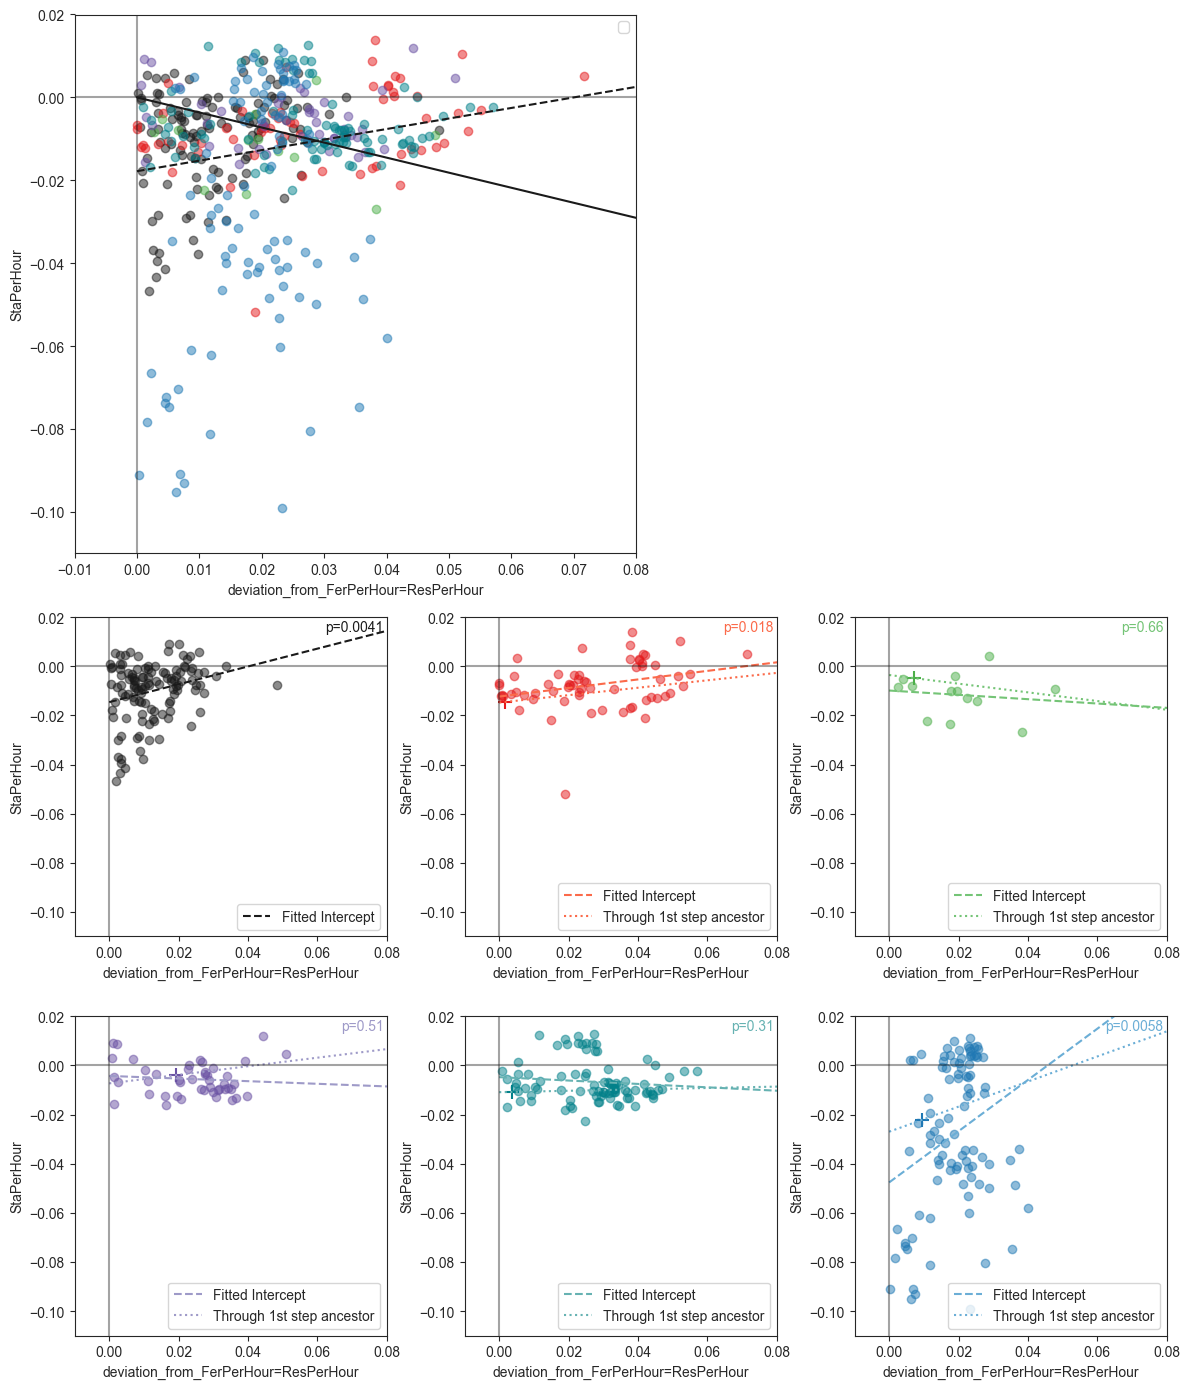

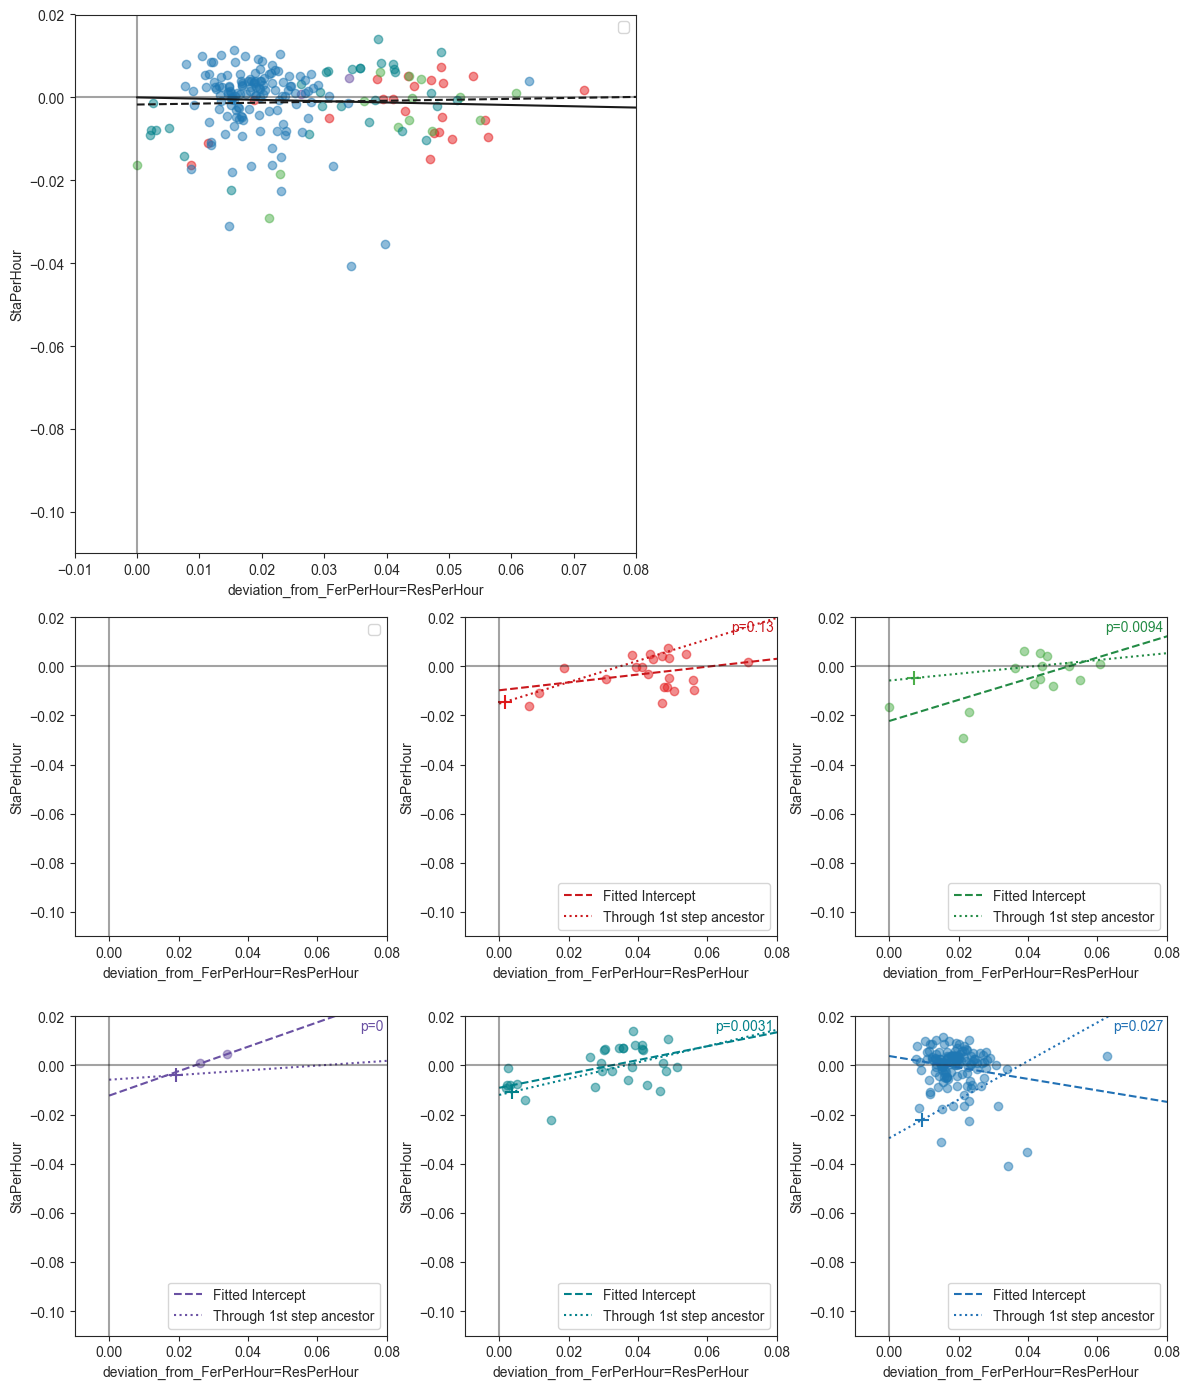

In [72]:

evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]
evo_cond_list = [['Evo2D'],['Evo3D']]
ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 
xdata = 'FerPerHour+ResPerHour'
ydata = 'StaPerHour'

merged_fitness['deviation_from_FerPerHour=ResPerHour'] = np.abs(merged_fitness['ResPerHour']- merged_fitness['FerPerHour'])/np.sqrt(2)
xdata = 'deviation_from_FerPerHour=ResPerHour'
ydata = 'StaPerHour'

these_xlims = [-0.01,0.08]

# merged_fitness['ResPerHour+StaPerHour'] = merged_fitness['ResPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'ResPerHour+StaPerHour'
# ydata = 'FerPerHour'

# merged_fitness['FerPerHour+StaPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'FerPerHour+StaPerHour'
# ydata = 'ResPerHour'
                 
for evo_cond in evo_cond_list:
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,2,2],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        
        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])


        this_anc = merged_fitness


#         this_pure_diploid = this_anc[(this_anc['ancestor'].isin(ancs)) & (this_anc['class_new']=='pure_diploids')]

#         sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
#                                 color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

#         this_neutral_haploid = this_anc[(this_anc['ancestor'].isin(ancs)) & (this_anc['class_new']=='neutral_haploids')]

#         sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
#                                 color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
        this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

        for anc in ancs:
            anc_here = this_data[this_data['ancestor']==anc]
            plt.scatter(anc_here[xdata].values,
                        anc_here[ydata].values,
                        alpha=0.5,color=tools.anc_color_map[anc])
            
            if len(anc_here[xdata].values) > 0 and len(ancs) == 1:
#                 print(anc)
#                 print(evo_cond)
#                 reg = LinearRegression(fit_intercept = False).fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)

#                 xs = np.linspace(0,3,100)
#                 plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through Origin')
            
                reg2 = LinearRegression().fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Fitted Intercept')
                
                slope, intercept, r_value, p_value, std_err = stats.linregress(x=anc_here[xdata].values.reshape(-1, 1)[:,0],
                                                                               y=anc_here[ydata].values)
            
                print(anc,evo_cond,slope,intercept,p_value)
                plt.text(x=0.99,y=0.99,s=f'p={p_value:.2g}',transform=plt.gca().transAxes,
                         color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],ha='right',va='top')
                
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                    reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                                  ,this_data[ydata].values-background_mutant[ydata].values)

                    xs = np.linspace(0,3,100)
                    plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                             ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through 1st step ancestor')
    #                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
    #                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
             
        if len(ancs) > 1:

            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color='k')

            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color='k')
            
        elif ancs != ['WT']:
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancs[0]]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[ancs[0]],s=100)
            
    

        plt.xlim(these_xlims[0],these_xlims[1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(xdata)
        plt.ylabel(ydata)
        plt.legend()

        plt.axhline(0,color='k',alpha=0.4)
        plt.axvline(0,color='k',alpha=0.4)

    plt.tight_layout()
                 
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.png',bbox_inches='tight',dpi=300)

ValueError: Length of values (119) does not match length of index (1)

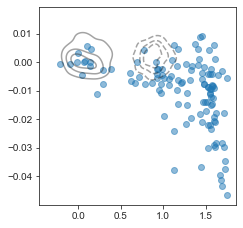

In [127]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

xdata = 'Fit2D_early_fitness'
ydata = 'StaPerHour'


plt.figure(figsize=(12,8))
for a,anc in enumerate(ancestor_list):
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
    for evo_cond in evo_cond_list:
        
        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

#             plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
#                                     marker='+',color=tools.anc_color_map[anc],s=100)
            
        else:
            background_mutant = {}
            background_mutant[xdata] = [0]
            background_mutant[ydata] = [0]
            
            background_mutant = p.DataFrame(background_mutant)
            
#             plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
#                                     marker='+',color=tools.anc_color_map[anc],s=100)
            
    
        this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

        sns.kdeplot(x=this_pure_diploid[xdata].values,
                    y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

        this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

        sns.kdeplot(x=this_neutral_haploid[xdata].values,
                    y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        

        plt.scatter(this_data[xdata].values-background_mutant[xdata].values[0],
                    this_data[ydata].values-background_mutant[ydata].values[0],
                    alpha=0.5)
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
        if len(this_data[xdata].values) > 0:
            reg = LinearRegression(fit_intercept = False).fit((this_data[xdata].values-background_mutant[xdata]).reshape(-1, 1),
                                          this_data[ydata].values-background_mutant[ydata])

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            reg2 = LinearRegression().fit((this_data[xdata].values-background_mutant[xdata]).reshape(-1, 1),
                                          this_data[ydata].values-background_mutant[ydata])

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color='k')
        

            
    plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)

In [48]:
p.DataFrame(background_mutant)

ValueError: If using all scalar values, you must pass an index

In [29]:
reg.score(this_data['Fit2D_early_fitness'].values.reshape(-1, 1),this_data['StaPerHour'].values)

0.05974196903802498

In [30]:
reg.coef_

array([-0.00951696])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

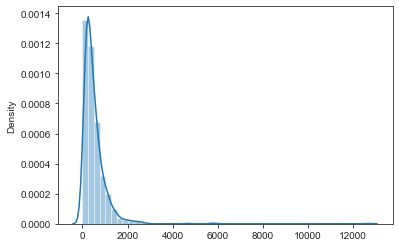

In [46]:
sns.distplot(merged_fitness[merged_fitness['source_publication']=='This_study']['Fit1D-2%-R1-T2'].values)

(0.0, 100.0)

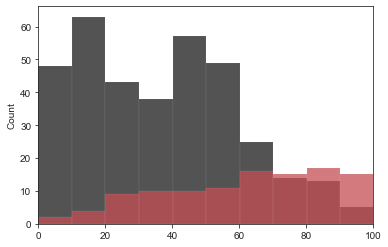

In [78]:
timepoint= 'Fit2D-2%-T0'
timepoint= 'Fit2D-2%-R1-T2'
plt.figure()
counts,bins = np.histogram(merged_fitness[merged_fitness['source_publication']=='This_study'][timepoint].values,
                          bins=np.linspace(0,5000,500))
sns.histplot(merged_fitness[merged_fitness['source_publication']=='Venkataram2015'][timepoint].values,color='k',bins=bins)
sns.histplot(merged_fitness[merged_fitness['source_publication']=='This_study'][timepoint].values,color='r',bins=bins)
plt.xlim(0,100)

In [92]:
timepoints = ['Fit2D-5%-T0','Fit2D-5%-R1-T2','Fit1D-5%-T0','Fit1D-5%-R1-T2']

count_threshold = 50

sum(np.all(merged_fitness[merged_fitness['source_publication']=='This_study'][timepoints].values < count_threshold,axis=1))

2

In [82]:
len(merged_fitness[merged_fitness['source_publication']=='This_study'].values)

1262

In [ ]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

xdata = 'Fit2D_early_fitness'
ydata = 'StaPerHour'


plt.figure(figsize=(12,8))
for a,anc_list in enumerate(ancestor_list):
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor'].isin(anc_list)]
    for evo_cond in evo_cond_list:
        
        for anc in anc_list
    
            this_pure_diploid = this_anc[(this_anc['ancestor'].isin(anc)) & (this_anc['class_new']=='pure_diploids')]

            sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                    color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

            this_neutral_haploid = this_anc[(this_anc['ancestor'].isin(anc)) & (this_anc['class_new']=='neutral_haploids')]

            sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                    color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
        
        if anc != 'WT':
            plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.3,
                        color=tools.anc_evo_cond_color_map[anc][evo_cond],marker=tools.evo_cond_marker_map[evo_cond])
        else:
            plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.3,color='k')
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
        if len(this_data[xdata].values) > 0:
            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                              ,this_data[ydata].values-background_mutant[ydata].values)
                


                xs = np.linspace(0,3,100)
                plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                         ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
#                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
#                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])

        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
            
    plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)
plt.tight_layout()